U ovoj Jupyter bilježnici istražit ćemo i replicirati rezultate dobivene u članku "A Machine Learning Strategy for Predicting March Madness Winners" by Gumm, Barrett, and Hu. U radu se raspravlja o izazovima i predviđanju pobjednika na muškom košarkaškom turniru NCAA Division I, te je predstavljen model koji je korišten za sudjelovanje na Kaggle Machine Learning March Mania natjecanju. <br>
NCAA Division I muški košarkaški turnir, poznatiji kao March Madness popularan je sportski događaj koji privlači veliku pažnju, veliku količinu klađenja i čije predviđanje pobjednika turnira predstavlja veliki izazov.

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# 1. Priprema i vizualizacija podataka

Prvo ćemo učitati naš skup podataka, koji nam se sastoji od 7 tablica. To su nam regular_season_results, sample_submission, seasons, teams, tourney_results, tourney_seeds i tourney_slots. Zatim ćemo za svaku od tablica napraviti deskriptivnu statistiku, potražiti da li nam tablica sadrži monotone atribute, stršeće vrijednosti, nedostajuće podatke, nekonzistentne podatke te ćemo ih prikazati grafički.

In [70]:
regular_season_results = pd.read_csv("regular_season_results.csv")
sample_submission = pd.read_csv("sample_submission.csv")
seasons = pd.read_csv("seasons.csv")
teams = pd.read_csv("teams.csv")
tourney_results = pd.read_csv("tourney_results.csv")
tourney_seeds = pd.read_csv("tourney_seeds.csv")
tourney_slots = pd.read_csv("tourney_slots.csv")

# 1.1 regular_season_results

Prva tablica koju ćemo obraditi je tablica regular_season_results koja sadrži rezultate utakmica iz regularnog dijela sezone.

In [71]:
regular_season_results

,season,daynum,wteam,wscore,lteam,lscore,wloc,numot
0,A,16,511,91,647,57,H,NaN
1,A,16,515,75,812,67,H,NaN
2,A,16,606,87,658,67,H,NaN
3,A,16,670,73,573,65,H,NaN
4,A,16,721,99,632,68,H,NaN
...,...,...,...,...,...,...,...,...
91219,S,132,592,61,640,60,N,0.0
91220,S,132,671,69,670,55,N,0.0
91221,S,132,779,65,825,61,N,0.0
91222,S,132,811,82,605,81,N,1.0


Značajke tablice regular_season_results:
- season - identifikator sezone
- daynum - cijeli broj koji predstavlja dan igranja utakmice odnosno pomak od datuma "dayzero" u datoteci "seasons.csv"
- wteam - id ekipe koja je pobijedila utakmicu
- wscore - broj poena koje je zabila pobjednička ekipa
- lteam - id ekipe koja je izgubila utakmicu
- lscore - broj poena koje je zabila gubitnička ekipa
- wloc - identificira lokaciju pobjedničkog tima
- numot - označava broj produžetaka u igri

Sada ćemo pokazati deskriptivnu statistiku za svaku značajku iz tablice.

In [72]:
regular_season_results.describe()

,daynum,wteam,wscore,lteam,lscore,numot
count,91224.000000,91224.000000,91224.000000,91224.000000,91224.000000,51333.000000
mean,73.410133,680.981058,75.370440,677.047400,63.208860,0.072000
std,34.210997,103.099502,11.408528,102.950054,10.940295,0.313278
min,0.000000,501.000000,34.000000,501.000000,20.000000,0.000000
25%,44.000000,592.000000,68.000000,587.000000,56.000000,0.000000
50%,75.000000,678.000000,75.000000,675.000000,63.000000,0.000000
75%,103.000000,772.000000,83.000000,768.000000,70.000000,0.000000
max,133.000000,856.000000,153.000000,856.000000,140.000000,6.000000


Sljedeće ćemo pogledati koliko ima značajki koje imaju različitu vrijednost za svaki upis te da li postoje monotoni atributi.

In [73]:
regular_season_results.nunique()

season     19
daynum    134
wteam     356
wscore    108
lteam     356
lscore    104
wloc        3
numot       7
dtype: int64

Možemo vidjeti da u ovom slučaju nemamo kandidata za monotoni atribut. <br>
Sljedeće ćemo pogledati koliko ima nedostajućih podataka odnosno koliko ima null vrijednosti po svakoj značajki.

In [74]:
regular_season_results.isna().sum()

season        0
daynum        0
wteam         0
wscore        0
lteam         0
lscore        0
wloc          0
numot     39891
dtype: int64

Vidimo da nam značajka numot ima puno null vrijednosti, a s obzirom na to da inače ne želimo imati null vrijednosti u tablici, nužno je nešto napraviti s tim zapisima. Imamo više opcija kako to možemo riješiti. Možemo ih zamijeniti srednjom vrijednošću ali to nema smisla jer nam je srednja vrijednost decimalni broj,a broj produžetaka nam mora biti cijeli broj. Izbacivanje tih zapisa također nema smisla jer ih ima previše (44 %) i time bi izgubili previše podataka. Opcija za koju sam se ja odlučio je izbacivanje te značajke iz tablice. To je najbolja opcija jer vidimo da veliki broj zapisa ima vrijednost null, a od zapisa koji nemaju null vrijednost većina ih ima vrijednost 0 što možemo vidjeti iz podatka da je srednja vrijednost 0.072.

In [75]:
regular_season_results.drop(['numot'], axis=1, inplace=True)
regular_season_results

,season,daynum,wteam,wscore,lteam,lscore,wloc
0,A,16,511,91,647,57,H
1,A,16,515,75,812,67,H
2,A,16,606,87,658,67,H
3,A,16,670,73,573,65,H
4,A,16,721,99,632,68,H
...,...,...,...,...,...,...,...
91219,S,132,592,61,640,60,N
91220,S,132,671,69,670,55,N
91221,S,132,779,65,825,61,N
91222,S,132,811,82,605,81,N


Sljedeće što ćemo provjeriti je ima li u podacima stršećih vrijednosti. Na temelju deskriptivne statistike koju smo ispisali, možemo vidjeti da su nam kandidati za stršeće podatke značajke wscore i lscore. Sumnjivi su nam zapisi s premalo ili previše koševa. Provjerit ćemo koliko ima zapisa u kojima je wscore manji od 50 poena, koliko je zapisa u kojima je wscore veći od 120 poena te koliko ima zapisa u kojima je lscore manji od 30 poena i koliko je zapisa u kojima je lscore veći od 120 poena.

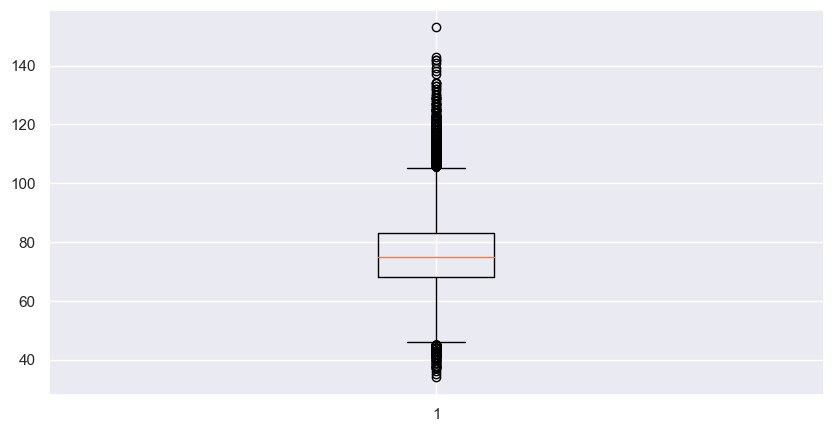

In [76]:
plt.boxplot(regular_season_results.wscore)
plt.show()

In [77]:
print('wscore > 120: ', (regular_season_results.wscore > 120).sum())
print('wscore > 130: ', (regular_season_results.wscore > 130).sum())
print('wscore > 140: ', (regular_season_results.wscore > 140).sum())
regular_season_results[regular_season_results.wscore > 140]

wscore > 120:  70
wscore > 130:  16
wscore > 140:  5


,season,daynum,wteam,wscore,lteam,lscore,wloc
185,A,29,602,142,800,127,H
813,A,48,802,141,734,50,H
8808,C,33,788,153,803,87,H
18449,E,59,788,143,608,110,H
34527,H,110,776,142,648,140,H


In [78]:
print('wscore < 50: ', (regular_season_results.wscore < 50).sum())
print('wscore < 40: ', (regular_season_results.wscore < 40).sum())
regular_season_results[regular_season_results.wscore < 40]

wscore < 50:  547
wscore < 40:  17


,season,daynum,wteam,wscore,lteam,lscore,wloc
8319,C,16,736,38,695,36,H
17023,E,19,736,37,679,35,H
25857,F,126,602,35,816,33,N
35758,I,27,524,38,545,34,N
38859,I,105,803,37,502,35,H
40453,J,29,841,37,620,36,A
41254,J,52,647,38,626,37,N
48820,K,117,783,39,841,37,A
58995,M,117,683,39,571,36,A
63741,N,107,729,38,623,33,A


Možemo vidjeti da zapisa manjih od 40 ima dosta tako da tu nećemo ništa poduzeti jer s obzirom na broj zapisa tu nije došlo do greške u upisivanju podataka. Što se tiče zapisa većih od 120 njih isto ima dosta te tu također nećemo ništa poduzimati. Vidimo da jedna vrijednost malo više odskače od ostalih to je zapis s vrijednošću wscore 153, ali tu nećemo isto ništa poduzimati jer u košarci je moguće da ekipa zabije toliko poena.

Sada ćemo pogledati postoje li stršeće vrijednosti među zapisima značajke lscore.

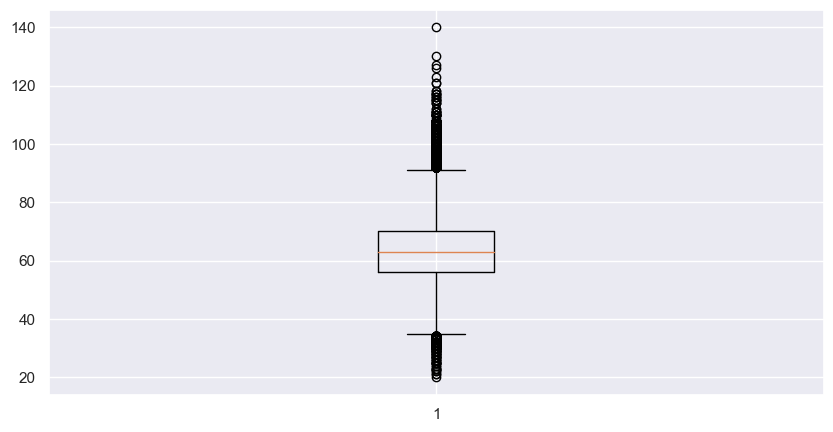

In [79]:
plt.boxplot(regular_season_results.lscore)
plt.show()

In [80]:
print('lscore < 30: ', (regular_season_results.lscore < 30).sum())
regular_season_results[regular_season_results.lscore < 30]

lscore < 30:  41


,season,daynum,wteam,wscore,lteam,lscore,wloc
2800,A,99,551,77,850,28,H
4547,B,36,695,57,848,28,H
5464,B,64,695,83,514,23,H
5487,B,66,553,61,600,21,H
5738,B,71,695,75,803,25,H
12654,D,19,849,66,654,29,H
13524,D,44,736,68,533,27,H
17199,E,25,587,48,715,26,N
19584,E,87,671,59,715,29,A
26065,G,18,539,56,582,27,H


In [81]:
print('lscore > 120: ', (regular_season_results.lscore > 120).sum())
regular_season_results[regular_season_results.lscore > 120]

lscore > 120:  7


,season,daynum,wteam,wscore,lteam,lscore,wloc
185,A,29,602,142,800,127,H
11328,C,101,719,122,537,121,H
14022,D,63,819,125,751,123,A
18082,E,49,661,127,836,126,A
26753,G,33,750,133,588,130,A
34527,H,110,776,142,648,140,H
62811,N,87,823,123,548,121,A


Možemo vidjeti da zapisa manjih od 30 ima dosta tako da tu nećemo ništa poduzeti jer s obzirom na broj zapisa tu nije došlo do greške u upisivanju podataka. Zapisa većih od 120 ima samo 7 ali ima ih dovoljno da je vjerojatnije da su ispravni nego da je došlo do greške prilikom upisivanja podataka. Isto tako vidimo da jedna vrijednost malo više odskače od ostalih. To je zapis s lscore 140, ali tu isto nećemo ništa poduzimati jer kao i kod wscore maloprije gdje smo imali vrijednost od 153, događa se da u košarci poražena ekipa zabije 140 poena.

Sljedeći korak je grafički prikazati podatke. Prvo što ćemo pogledati je kako lokacija utakmice utječe na pobjednika utakmice.

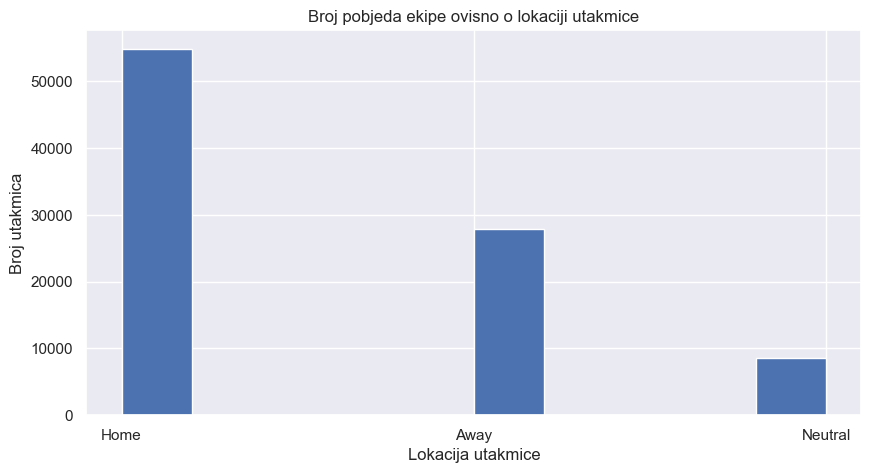

In [82]:
plt.hist(regular_season_results.wloc)
plt.title("Broj pobjeda ekipe ovisno o lokaciji utakmice")
plt.xlabel("Lokacija utakmice")
plt.ylabel("Broj utakmica")
plt.xticks(["H", "A", "N"], ["Home", "Away", "Neutral"])
plt.show()

Možemo vidjeti na gore prikazanom histogramu da ako je ekipa bila domaćin utakmice vjerojatnije je da će pobijediti u utakmici nego da je igrala u gostima ili na neutralnom terenu. <br>
Sljedeću zanimljivu stvar koju ćemo pogledati je koje ekipe su po sezonama u prosjeku zabijale najviše poena, i koje su ekipe u prosjeku po sezonama zabijale najmanje poena.

In [83]:
def getBestAndWorstAveragePoints(sezona):
    ekipa_lista_poena = {}
    ekipa_prosjek_poena = []
    top_tri_ekipe = []
    najlosije_tri_ekipe = []
    ekipe = []
    for i in range(501, 857):
        ekipe.append(i)
    
    for i in ekipe:
        if i not in ekipa_lista_poena:
            ekipa_lista_poena[i] = []
            
    #filtriramo podatke za određenu sezonu
    regular_season_results_pom = regular_season_results[regular_season_results.season == sezona]
    
    #Prolazimo kroz sve zapise i za svaku ekipu spremamo u rječnik koliko su zabili poena u nekoj utakmici. Zatim za svaku ekipu
    #izračunavamo prosjek njihovih poena i spremamo par (id ekipe, prosjek poena) u jednu listu.
    for index, row in regular_season_results_pom.iterrows():
        ekipa_lista_poena[row.wteam].append(row.wscore)
        ekipa_lista_poena[row.lteam].append(row.lscore)
    for j in ekipe:
        if len(ekipa_lista_poena[j]) == 0:
            ekipa_prosjek_poena.append([j, 0])
        else:
            ekipa_prosjek_poena.append([j, np.nanmean(ekipa_lista_poena[j])])
            
    #Sortiramo listu po prosjeku poena, te u posebnu listu spremamo tri ekipe sa najvećim prosjekom, i u posebnu listu spremamo
    #tri ekipe sa najlošijim prosjekom (ekipe koje u prosjeku imaju nula preskačemo jer to znači da nisu odigrale niti jednu
    #utakmicu te sezone).
    ekipa_prosjek_poena = sorted(ekipa_prosjek_poena, key=lambda x: x[1], reverse=True)
    for i in range(3):
        top_tri_ekipe.append(ekipa_prosjek_poena[i])
    i = len(ekipa_prosjek_poena) - 1
    while len(najlosije_tri_ekipe) < 3:
        if ekipa_prosjek_poena[i][1] != 0:
            najlosije_tri_ekipe.append(ekipa_prosjek_poena[i])
        i -= 1
    
    #Spremamo dobivene najbolje i najlošije ekipe te njihov projek poena u rječnike i vraćamo oba rječnika
    d1 = {
        "Momčad": pd.Series([teams[teams.id == i[0]]['name'].tolist()[0] for i in top_tri_ekipe], index=[i[0] for i in top_tri_ekipe]),
        "Projek poena": pd.Series([i[1] for i in top_tri_ekipe], index=[i[0] for i in top_tri_ekipe]),
    }
    d2 = {
        "Momčad": pd.Series([teams[teams.id == i[0]]['name'].tolist()[0] for i in najlosije_tri_ekipe], index=[i[0] for i in najlosije_tri_ekipe]),
        "Projek poena": pd.Series([i[1] for i in najlosije_tri_ekipe], index=[i[0] for i in najlosije_tri_ekipe]),
    }
    return d1, d2


In [84]:
#Funkcija za printanje DataFrameova
from IPython.display import display_html
def printanje(d1,d2, sezona):
    print("Sezona:", i)
    df1_styler = pd.DataFrame(d1).style.set_table_attributes("style='display:inline'").set_caption('Najbolje ekipe')
    df2_styler = pd.DataFrame(d2).style.set_table_attributes("style='display:inline'").set_caption('Najlošije ekipe')
    display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)
    print("-"*60)

In [85]:
#Iteriramo po svim sezonama i ispisujemo najbolje i najlošije tri ekipe te njihov prosjek poena.
sezone = "ABCDEFGHIJKLMNOPQRS"
print("Ekipe sa najviše i najmanje poena u prosjeku po sezonama\n")
for i in sezone:
    d1, d2 = getBestAndWorstAveragePoints(i)
    printanje(d1, d2, i)

Ekipe sa najviše i najmanje poena u prosjeku po sezonama

Sezona: A


,Momčad,Projek poena
800,Troy,92.440000
640,Kentucky,91.900000
661,Marshall,90.222222
,Momčad,Projek poena
600,Ga Southern,55.480000
726,Oregon St,55.538462
768,South Alabama,56.730769


------------------------------------------------------------
Sezona: B


,Momčad,Projek poena
648,Long Island,91.551724
636,Kansas,85.406250
511,Arizona,85.107143
,Momčad,Projek poena
531,Brown,53.269231
803,TX Pan American,54.423077
573,DePaul,55.269231


------------------------------------------------------------
Sezona: C


,Momčad,Projek poena
788,TCU,97.322581
648,Long Island,93.571429
511,Arizona,92.193548
,Momčad,Projek poena
567,Dartmouth,56.692308
558,Columbia,56.800000
531,Brown,56.846154


------------------------------------------------------------
Sezona: D


,Momčad,Projek poena
577,Duke,93.333333
766,Siena,86.933333
707,Norfolk St,86.222222
,Momčad,Projek poena
548,Chicago St,54.629630
616,Holy Cross,57.230769
558,Columbia,57.666667


------------------------------------------------------------
Sezona: E


,Momčad,Projek poena
577,Duke,89.129032
788,TCU,87.483871
766,Siena,86.870968
,Momčad,Projek poena
715,Northwestern,51.500000
517,Army,51.884615
844,WI Green Bay,56.633333


------------------------------------------------------------
Sezona: F


,Momčad,Projek poena
788,TCU,92.033333
577,Duke,91.424242
662,Maryland,85.741935
,Momčad,Projek poena
759,Savannah St,52.714286
558,Columbia,56.560000
761,SE Louisiana,57.000000


------------------------------------------------------------
Sezona: G


,Momčad,Projek poena
636,Kansas,91.033333
577,Duke,89.718750
725,Oregon,86.400000
,Momčad,Projek poena
759,Savannah St,53.769231
620,Idaho,54.000000
558,Columbia,54.846154


------------------------------------------------------------
Sezona: H


,Momčad,Projek poena
511,Arizona,85.214286
510,Appalachian St,83.269231
725,Oregon,82.218750
,Momčad,Projek poena
558,Columbia,49.629630
705,Nicholls St,53.407407
517,Army,53.680000


------------------------------------------------------------
Sezona: I


,Momčad,Projek poena
511,Arizona,87.517241
839,Wake Forest,83.821429
800,Troy,83.571429
,Momčad,Projek poena
517,Army,49.240000
514,Ark Pine Bluff,52.222222
594,Florida Intl,54.280000


------------------------------------------------------------
Sezona: J


,Momčad,Projek poena
708,North Carolina,88.774194
840,Washington,86.225806
704,Niagara,85.172414
,Momčad,Projek poena
517,Army,54.320000
841,Washington St,55.928571
736,Princeton,56.148148


------------------------------------------------------------
Sezona: K


,Momčad,Projek poena
540,Campbell,82.821429
577,Duke,82.515152
647,Long Beach St,82.413793
,Momčad,Projek poena
743,Richmond,52.066667
736,Princeton,52.153846
517,Army,54.480000


------------------------------------------------------------
Sezona: L


,Momčad,Projek poena
832,VMI,95.551724
708,North Carolina,86.264706
582,E Washington,83.153846
,Momčad,Projek poena
736,Princeton,50.357143
523,Bethune-Cookman,53.000000
710,North Florida,53.481481


------------------------------------------------------------
Sezona: M


,Momčad,Projek poena
708,North Carolina,88.705882
832,VMI,84.920000
577,Duke,84.125000
,Momčad,Projek poena
694,NC Central,54.777778
735,Presbyterian,55.555556
706,NJIT,55.931034


------------------------------------------------------------
Sezona: N


,Momčad,Projek poena
832,VMI,90.178571
708,North Carolina,89.387097
548,Chicago St,82.833333
,Momčad,Projek poena
706,NJIT,49.838710
581,E Michigan,54.933333
652,Loy Marymount,55.677419


------------------------------------------------------------
Sezona: O


,Momčad,Projek poena
832,VMI,86.080000
536,BYU,82.606061
829,Villanova,82.548387
,Momčad,Projek poena
532,Bryant,51.866667
567,Dartmouth,52.962963
798,Toledo,53.838710


------------------------------------------------------------
Sezona: P


,Momčad,Projek poena
718,Oakland,85.090909
832,VMI,83.518519
840,Washington,83.515152
,Momčad,Projek poena
834,W Illinois,55.888889
773,Southern Univ,55.962963
759,Savannah St,56.461538


------------------------------------------------------------
Sezona: Q


,Momčad,Projek poena
627,Iona,83.250000
708,North Carolina,81.970588
648,Long Island,81.878788
,Momčad,Projek poena
799,Towson,51.468750
818,USC,52.593750
581,E Michigan,52.967742


------------------------------------------------------------
Sezona: R


,Momčad,Projek poena
627,Iona,80.696970
625,Indiana,80.000000
629,Iowa St,79.636364
,Momčad,Projek poena
608,Grambling,49.678571
619,Howard,51.275862
690,N Illinois,53.344828


------------------------------------------------------------
Sezona: S


,Momčad,Projek poena
716,Northwestern LA,85.448276
536,BYU,84.212121
627,Iona,83.500000
,Momčad,Projek poena
700,New Hampshire,56.586207
774,Southern Utah,58.035714
692,Navy,59.379310


------------------------------------------------------------


Sada smo pogledali koje su ekipe u prosjeku zabijale  najviše poena i koje su ekipe u prosjeku zabijale najmanje poena po sezoni. Sad ćemo pogledati koje ekipe su imale najveći, a koje ekipe su imale najmanji postotak pobjeda.

In [86]:
def getBestAndWorstTeams(sezona):
    ekipa_broj_pobjeda_poraza = {}
    postotak_pobjeda = {}
    top_tri_ekipe = []
    najlosije_tri_ekipe = []
    ekipe = []
    for i in range(501, 857):
        ekipe.append(i)

    for j in ekipe:
        if j not in ekipa_broj_pobjeda_poraza:
            ekipa_broj_pobjeda_poraza[j] = [0, 0]
        if j not in postotak_pobjeda:
            postotak_pobjeda[j] = 0
    
    #Filtriramo podatke za određenu sezonu
    regular_season_results_pom = regular_season_results[regular_season_results.season == sezona]
    
    #Iteriramo po svim zapisima te za svaku ekipu zapisujemo u rječnik koliko imaju pobjeda i poraza u sezoni
    for index, row in regular_season_results_pom.iterrows():
        ekipa_broj_pobjeda_poraza[row.wteam][0] += 1
        ekipa_broj_pobjeda_poraza[row.lteam][1] += 1
        
    #Izračunavamo postotak pobjeda svake ekipe i zapisujemo taj podataka u rječnik
    for j in ekipa_broj_pobjeda_poraza.keys():
        if ekipa_broj_pobjeda_poraza[j][0] + ekipa_broj_pobjeda_poraza[j][1] != 0:
            postotak_pobjeda[j] = ekipa_broj_pobjeda_poraza[j][0] / (ekipa_broj_pobjeda_poraza[j][0] + ekipa_broj_pobjeda_poraza[j][1])
    
    #Sortiramo rječnik sa postocima pobjeda te ekipe sa tri najbolja i ekipe sa tri najlošija postotka spremamo u liste
    sorted_dict_by_values = dict(sorted(postotak_pobjeda.items(), key=lambda item: item[1]))
    brojac = 0
    for j in sorted_dict_by_values.keys():
        brojac += 1
        if sorted_dict_by_values[j] != 0 and len(najlosije_tri_ekipe) < 3:
            najlosije_tri_ekipe.append([j, sorted_dict_by_values[j]])
        if brojac > 353:
            top_tri_ekipe.append([j, sorted_dict_by_values[j]])
    top_tri_ekipe = sorted(top_tri_ekipe, key=lambda x: x[1], reverse=True)
       
    #Spremamo dobivene najbolje i najlošije ekipe te njihov postotak pobjeda u rječnike i vraćamo oba rječnika
    d1 = {
        "Momčad": pd.Series([teams[teams.id == i[0]]['name'].tolist()[0] for i in top_tri_ekipe], index=[i[0] for i in top_tri_ekipe]),
        "Postotak pobjeda": pd.Series([i[1] for i in top_tri_ekipe], index=[i[0] for i in top_tri_ekipe]),
    }
    d2 = {
        "Momčad": pd.Series([teams[teams.id == i[0]]['name'].tolist()[0] for i in najlosije_tri_ekipe], index=[i[0] for i in najlosije_tri_ekipe]),
        "Postotak pobjeda": pd.Series([i[1] for i in najlosije_tri_ekipe], index=[i[0] for i in najlosije_tri_ekipe]),
    }

    return d1, d2

In [87]:
from IPython.display import display_html

#Iteriramo po svim sezonama i ispisujemo najbolje i najlošije tri ekipe po postotku pobjeda.
sezone = "ABCDEFGHIJKLMNOPQRS"
print("Ekipe sa najvećim i najmanjim postotkom pobjeda\n")
for i in sezone:
    d1, d2 = getBestAndWorstTeams(i)
    printanje(d1, d2, i)

Ekipe sa najvećim i najmanjim postotkom pobjeda

Sezona: A


,Momčad,Postotak pobjeda
663,Massachusetts,0.968750
796,Texas Tech,0.965517
559,Connecticut,0.937500
,Momčad,Postotak pobjeda
582,E Washington,0.041667
850,Wofford,0.043478
548,Chicago St,0.074074


------------------------------------------------------------
Sezona: B


,Momčad,Postotak pobjeda
636,Kansas,0.968750
554,Col Charleston,0.925926
673,Minnesota,0.896552
,Momčad,Postotak pobjeda
644,Lehigh,0.037037
536,BYU,0.038462
803,TX Pan American,0.038462


------------------------------------------------------------
Sezona: C


,Momčad,Postotak pobjeda
736,Princeton,0.961538
636,Kansas,0.916667
708,North Carolina,0.909091
,Momčad,Postotak pobjeda
523,Bethune-Cookman,0.038462
566,CS Sacramento,0.040000
548,Chicago St,0.074074


------------------------------------------------------------
Sezona: D


,Momčad,Postotak pobjeda
577,Duke,0.969697
559,Connecticut,0.933333
554,Col Charleston,0.925926
,Momčad,Postotak pobjeda
619,Howard,0.074074
514,Ark Pine Bluff,0.080000
645,Liberty,0.083333


------------------------------------------------------------
Sezona: E


,Momčad,Postotak pobjeda
549,Cincinnati,0.903226
783,Stanford,0.892857
802,Tulsa,0.878788
,Momčad,Postotak pobjeda
590,FL Atlantic,0.034483
619,Howard,0.035714
832,VMI,0.080000


------------------------------------------------------------
Sezona: F


,Momčad,Postotak pobjeda
783,Stanford,0.931034
577,Duke,0.878788
605,Georgia St,0.870968
,Momčad,Postotak pobjeda
781,St Mary's CA,0.035714
514,Ark Pine Bluff,0.074074
711,North Texas,0.076923


------------------------------------------------------------
Sezona: G


,Momčad,Postotak pobjeda
549,Cincinnati,0.909091
577,Duke,0.906250
607,Gonzaga,0.903226
,Momčad,Postotak pobjeda
548,Chicago St,0.037037
705,Nicholls St,0.038462
514,Ark Pine Bluff,0.071429


------------------------------------------------------------
Sezona: H


,Momčad,Postotak pobjeda
640,Kentucky,0.906250
511,Arizona,0.892857
562,Creighton,0.878788
,Momčad,Postotak pobjeda
693,NC A&T,0.038462
791,Tennessee St,0.040000
596,Fordham,0.071429


------------------------------------------------------------
Sezona: I


,Momčad,Postotak pobjeda
783,Stanford,0.966667
779,St Joseph's PA,0.964286
607,Gonzaga,0.931034
,Momčad,Postotak pobjeda
653,Loyola MD,0.035714
514,Ark Pine Bluff,0.037037
552,Cleveland St,0.074074


------------------------------------------------------------
Sezona: J


,Momčad,Postotak pobjeda
623,Illinois,0.969697
727,Pacific,0.896552
708,North Carolina,0.870968
,Momčad,Postotak pobjeda
649,Longwood,0.033333
517,Army,0.040000
665,MD E Shore,0.071429


------------------------------------------------------------
Sezona: K


,Momčad,Postotak pobjeda
599,G Washington,0.928571
577,Duke,0.909091
666,Memphis,0.909091
,Momčad,Postotak pobjeda
633,Jacksonville,0.037037
759,Savannah St,0.037037
795,Texas St,0.083333


------------------------------------------------------------
Sezona: L


,Momčad,Postotak pobjeda
666,Memphis,0.909091
720,Ohio St,0.909091
636,Kansas,0.882353
,Momčad,Postotak pobjeda
710,North Florida,0.037037
627,Iona,0.066667
837,W Salem St,0.076923


------------------------------------------------------------
Sezona: M


,Momčad,Postotak pobjeda
666,Memphis,0.970588
708,North Carolina,0.941176
810,UCLA,0.909091
,Momčad,Postotak pobjeda
710,North Florida,0.071429
735,Presbyterian,0.074074
550,Citadel,0.076923


------------------------------------------------------------
Sezona: N


,Momčad,Postotak pobjeda
666,Memphis,0.911765
822,Utah St,0.878788
731,Pittsburgh,0.870968
,Momčad,Postotak pobjeda
706,NJIT,0.032258
566,CS Sacramento,0.068966
762,SE Missouri St,0.068966


------------------------------------------------------------
Sezona: O


,Momčad,Postotak pobjeda
636,Kansas,0.941176
640,Kentucky,0.941176
701,New Mexico,0.878788
,Momčad,Postotak pobjeda
532,Bryant,0.033333
659,Marist,0.033333
508,Alcorn St,0.064516


------------------------------------------------------------
Sezona: P


,Momčad,Postotak pobjeda
636,Kansas,0.941176
720,Ohio St,0.941176
754,San Diego St,0.937500
,Momčad,Postotak pobjeda
543,Centenary,0.035714
600,Ga Southern,0.068966
542,Cent Arkansas,0.076923


------------------------------------------------------------
Sezona: Q


,Momčad,Postotak pobjeda
687,Murray St,0.964286
640,Kentucky,0.941176
786,Syracuse,0.939394
,Momčad,Postotak pobjeda
799,Towson,0.031250
697,NE Omaha,0.062500
524,Binghamton,0.064516


------------------------------------------------------------
Sezona: R


,Momčad,Postotak pobjeda
607,Gonzaga,0.937500
666,Memphis,0.882353
701,New Mexico,0.852941
,Momčad,Postotak pobjeda
524,Binghamton,0.068966
665,MD E Shore,0.071429
643,Lamar,0.096774


------------------------------------------------------------
Sezona: S


,Momčad,Postotak pobjeda
846,Wichita St,1.000000
592,Florida,0.941176
765,SF Austin,0.935484
,Momčad,Postotak pobjeda
774,Southern Utah,0.035714
561,Cornell,0.037037
501,Abilene Chr,0.095238


------------------------------------------------------------


Nakon što smo pogledali koje ekipe imaju najveći i koje ekipe imaju najmanji postotak pobjeda, sljedeće što ćemo prikazati je prosječan broj poena ekipa koje su igrale doma, u gostima ili na neutralnom terenu kroz sve sezone. 

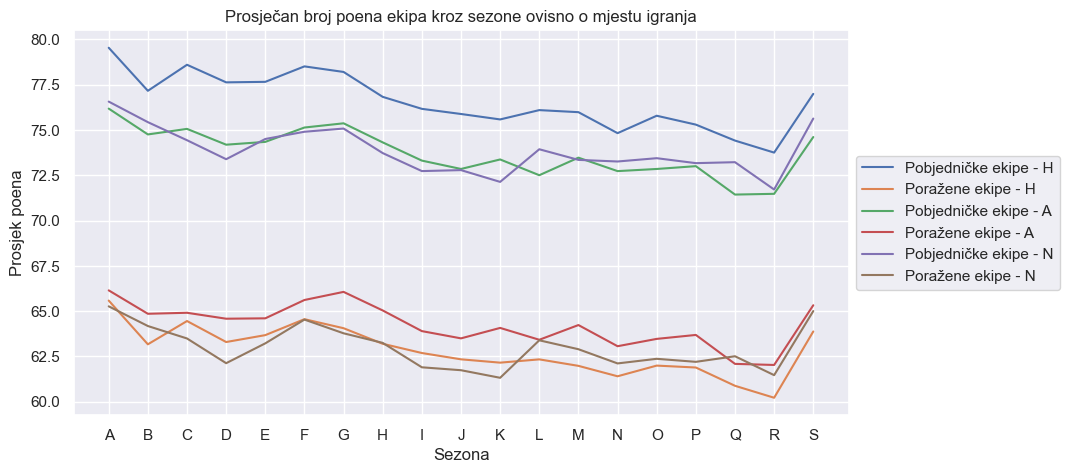

In [88]:
lokacije = ['H', 'A', 'N']
#Iteriramo po lokacijama na kojima se mogu održati utakmice, zatim iteriramo po svim sezonama. Za svaku sezonu spremamo ukupan
#broj poena pobjednika i ukupan broj poena poraženih ekipa ovisno o lokaciji u listu. Nakon toga računamo prosječni broj poena 
#pobjednika i prosječni broj poena poraženih ekipa te ih prikazujemo na grafu.
for i in lokacije:
    prosjeci_sezona_pobjede = []
    prosjeci_sezona_porazi = []
    
    for j in sezone:
        regular_season_results_pom = regular_season_results[(regular_season_results.season == j) & (regular_season_results.wloc == i)]
        pobjede = regular_season_results_pom['wscore'].tolist()
        porazi = regular_season_results_pom['lscore'].tolist()
        prosjeci_sezona_pobjede.append(np.nanmean(pobjede))
        prosjeci_sezona_porazi.append(np.nanmean(porazi))

    plt.plot(list(sezone), prosjeci_sezona_pobjede, label="Pobjedničke ekipe - " + i)
    plt.plot(list(sezone), prosjeci_sezona_porazi, label="Poražene ekipe - " + i)

plt.title("Prosječan broj poena ekipa kroz sezone ovisno o mjestu igranja")
plt.xlabel("Sezona")
plt.ylabel("Prosjek poena")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Sljedeći graf koji ćemo prikazati je pitni graf koji nam pokazuje omjer broja pobjeda i broja poraza određene ekipe na jednoj od lokacija ("home", "away", "neutral") za neku zadanu sezonu.

In [89]:
#Funckija kojom filtriramo podatke ovisno o listi vrijednosti koje primi kao argument. Nakon toga određujemo broj pobjeda i poraza 
#određene ekipe te spremamo te vrijednosti u listu vrijednosti i vraćamo tu listu.
def percentegOfWictoriesPerTeam(vrijednosti):
    if vrijednosti[1] == 'sve':
        regular_season_results_pom = regular_season_results[(regular_season_results.season == vrijednosti[2]) & 
                                                            ((regular_season_results.wteam == teams[teams.name == vrijednosti[0]]['id'].tolist()[0]) |
                                                            (regular_season_results.lteam == teams[teams.name == vrijednosti[0]]['id'].tolist()[0]))]
    else:
        regular_season_results_pom = regular_season_results[(regular_season_results.season == vrijednosti[2]) & 
                                                            (regular_season_results.wloc == vrijednosti[1]) &
                                                            ((regular_season_results.wteam == teams[teams.name == vrijednosti[0]]['id'].tolist()[0]) |
                                                            (regular_season_results.lteam == teams[teams.name == vrijednosti[0]]['id'].tolist()[0]))]

    pobjede = len(regular_season_results_pom[(regular_season_results_pom.wteam == teams[teams.name == vrijednosti[0]]['id'].tolist()[0])]['wteam'].tolist())
    porazi = len(regular_season_results_pom[(regular_season_results_pom.lteam == teams[teams.name == vrijednosti[0]]['id'].tolist()[0])]['lteam'].tolist())
    vrijednosti.append(pobjede)
    vrijednosti.append(porazi)
    return vrijednosti

In [90]:
#Crtanje pitnog grafa - omjer pobjeda i poraza neke ekipe ovisno o lokaciji i sezoni.
def crtanjePitnogGrafa(vrijednosti):
    labels = ["Postotak pobjeda", "Postotak poraza"]
    if vrijednosti[1] == 'sve':
        ispis = f"Omjer pobjeda i poraza ekipe '{vrijednosti[0]}' na svim lokacijama u sezoni '{vrijednosti[2]}'."
    else:
        ispis = f"Omjer pobjeda i poraza ekipe '{vrijednosti[0]}' na lokaciji '{vrijednosti[1]}' u sezoni '{vrijednosti[2]}'."
    if vrijednosti[3] != 0 or vrijednosti[4] != 0:
        plt.title(ispis)
        plt.pie(vrijednosti[3:], labels=labels, autopct='%1.1f%%', colors = ['r', 'b'])
        plt.show()
    else:
        print(f"Ekipa '{vrijednosti[0]}' nije odigrala niti jednu utakmicu na lokaciji '{vrijednosti[1]}' u sezoni '{vrijednosti[2]}'.")

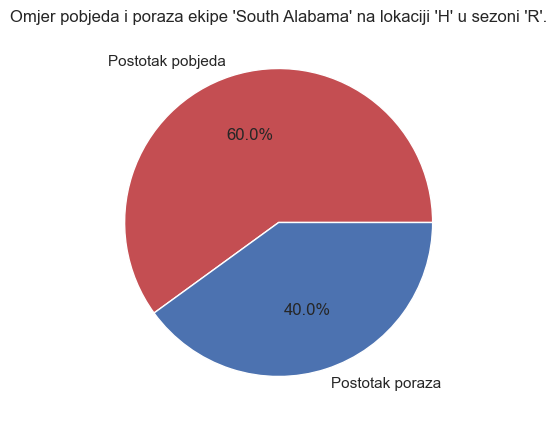

In [91]:
#Vrijednosti koje predajemo funkciji za izračunavanje broja pobjeda i poraza su ime ekipe na prvoj poziciji u listi, lokacija 
#utakmice na drugoj poziciji u listi (ako se preda riječ "sve", izračunavamo omjer pobjeda i poraza određene ekipe na svim 
#lokacijama za neku sezonu) te sezona na trečoj poziciji u listi. Funkcija za crtanje pitnog grafa prima listu s istim tim
#vrijednostima proširenima s brojem pobjeda i brojem poraza ekipe.
vrijednosti = ['South Alabama', 'H', 'R']
vrijednosti = percentegOfWictoriesPerTeam(vrijednosti)
crtanjePitnogGrafa(vrijednosti)

Zadnje što ćemo izračunati i prikazati za tablicu regular_season_results je korelaciju između svaka dva para značajki. S obzirom na to da se korelacijski faktor ne možemo računati s ne numeričkim vrijednostima, moramo nešto napraviti sa značajkama 'season' i 'wloc'. Možemo ih ukloniti iz tablice i računati korelacijski faktor bez njih ili im možemo promijeniti format koristeći LabelEncoder. U ovom slučaju koristiti ćemo LabelEncoder.

In [92]:
le = LabelEncoder()
le.fit(regular_season_results.loc[:,'wloc'])
regular_season_results.loc[:,'wloc'] = le.transform(regular_season_results.loc[:,'wloc'])

le.fit(regular_season_results.loc[:,'season'])
regular_season_results.loc[:,'season'] = le.transform(regular_season_results.loc[:,'season'])

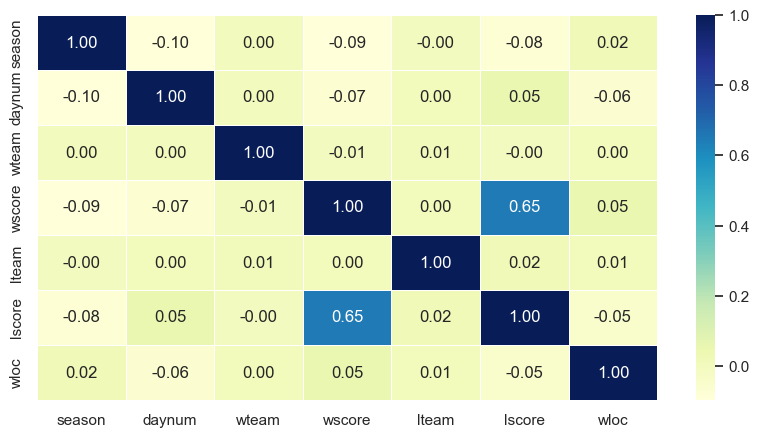

In [93]:
sns.set(rc={'figure.figsize':(10,5)})
sns.heatmap(regular_season_results.corr(), annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.show()

Iz dobivene toplinske mape možemo vidjeti da je korelacija između značajki slaba, osim za značajke 'wscore' i 'lscore'. Makar su nam značajke 'wscore' i 'lscore' visoko korelirane, nisu toliko visoko korelirane da bi jednu od njih mogli izbaciti i time smanjiti dimenzionalnost skupa.

# 1.2 seasons

Druga tablica koju ćemo obraditi je tablica seasons koja nam prikazuje početak i kraj svake sezone te divizije na koje je sezona bila podijeljena.

In [94]:
seasons

,season,years,dayzero,regionW,regionX,regionY,regionZ
0,A,1995-1996,10/30/1995,East,Midwest,Southeast,West
1,B,1996-1997,10/28/1996,East,Southeast,Midwest,West
2,C,1997-1998,10/27/1997,East,West,Midwest,South
3,D,1998-1999,10/26/1998,East,Midwest,South,West
4,E,1999-2000,11/01/1999,Midwest,West,East,South
5,F,2000-2001,10/30/2000,East,West,Midwest,South
6,G,2001-2002,10/29/2001,East,Midwest,South,West
7,H,2002-2003,11/04/2002,East,South,Midwest,West
8,I,2003-2004,11/03/2003,Atlanta,Phoenix,EastRutherford,StLouis
9,J,2004-2005,11/01/2004,Albuquerque,Chicago,Austin,Syracuse


Značajke tablice seasons:
- season - identifikator sezone
- years - godine u kojima se održala sezona
- dayzero - datum početka sezone
- regionW/X/Y/Z - četiri regije na finalnom turniru

Sada ćemo pokazati deskriptivnu statistiku za svaku značajku iz tablice, ali s obzirom na to da nam podaci nisu numerički analiza ove tablice neće biti duga. Uvijek imamo opciju da podatke pretvorimo u numeričke ali to ovdje ne bi imalo smisla.

In [95]:
seasons.describe()

,season,years,dayzero,regionW,regionX,regionY,regionZ
count,19,19,19,19,19,19,19
unique,19,19,19,4,7,7,6
top,A,1995-1996,10/30/1995,East,South,Midwest,West
freq,1,1,1,15,6,9,12


In [96]:
seasons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   season   19 non-null     object
 1   years    19 non-null     object
 2   dayzero  19 non-null     object
 3   regionW  19 non-null     object
 4   regionX  19 non-null     object
 5   regionY  19 non-null     object
 6   regionZ  19 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


In [97]:
seasons.nunique()

season     19
years      19
dayzero    19
regionW     4
regionX     7
regionY     7
regionZ     6
dtype: int64

In [98]:
seasons.isna().sum()

season     0
years      0
dayzero    0
regionW    0
regionX    0
regionY    0
regionZ    0
dtype: int64

Možemo vidjeti u gore dobivenim rezultatima da u tablici nema monotonih atributa i da u tablici nema null vrijednosti. Također u podacima nema stršećih vrijednosti niti ništa značajnog što bi mogli prikazati grafički.

# 1.3 teams

Treća tablica koju ćemo obraditi je tablica teams koja sadrži 356 različitih sveučilišnih timova koji su prisutni u barem jednoj od sezona od 1995.-1996. do 2013.-2014. 

In [99]:
teams

,id,name
0,501,Abilene Chr
1,502,Air Force
2,503,Akron
3,504,Alabama
4,505,Alabama A&M
...,...,...
351,852,Wyoming
352,853,Xavier
353,854,Yale
354,855,Youngstown St


Značajke tablice teams:
- id - identifikator ekipe
- name - ime ekipe

Sada ćemo pokazati deskriptivnu statistiku za svaku značajku iz tablice, ali s obzirom na to da nam je jedini numerički podatak id koji je monotono rastući atribut analiza ove tablice će biti sažeta kao i analiza tablice seasons.

In [100]:
teams.describe()

,id
count,356.000000
mean,678.500000
std,102.912584
min,501.000000
25%,589.750000
50%,678.500000
75%,767.250000
max,856.000000


In [101]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      356 non-null    int64 
 1   name    356 non-null    object
dtypes: int64(1), object(1)
memory usage: 5.7+ KB


In [102]:
teams.nunique()

id      356
name    356
dtype: int64

In [103]:
teams.isna().sum()

id      0
name    0
dtype: int64

Možemo vidjeti u gore dobivenim rezultatima da u tablici imamo monotoni atribut id, ali njega nećemo uklanjati jer nam je preko tog atributa ova tablica povezana s ostalim tablicama. U tablici također nema null vrijednosti niti stršećih vrijednosti niti ništa značajnog što bi mogli prikazati grafički.

# 1.4 tourney_seeds

Četvrta tablica koju ćemo obraditi je tablica tourney_seeds koja sadrži nositelje za posljednja 64 tima na svakom NCAA turniru, za svih 18 sezona. 

In [104]:
tourney_seeds

,season,seed,team
0,A,W01,663
1,A,W02,603
2,A,W03,796
3,A,W04,660
4,A,W05,729
...,...,...,...
1237,S,Z12,689
1238,S,Z13,702
1239,S,Z14,811
1240,S,Z15,509


Značajke tablice tourney_seeds:
- season - identifikator sezone
- seed - ovo je troznakovni identifikator nositelja 
- team - id ekipe

Kao i za prijašnje tablice sada ćemo pokazati deskriptivnu statistiku za svaku značajku iz tablice, ali s obzirom na to da nam je jedini numerički podatak značajka team s kojom ne možemo previše toga napraviti analiza ove tablice će također biti sažeta.

In [105]:
tourney_seeds.describe()

,team
count,1242.000000
mean,685.844605
std,103.133122
min,502.000000
25%,603.000000
50%,680.000000
75%,783.000000
max,853.000000


In [106]:
tourney_seeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   season  1242 non-null   object
 1   seed    1242 non-null   object
 2   team    1242 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 29.2+ KB


In [107]:
tourney_seeds.nunique()

season     19
seed       86
team      262
dtype: int64

In [108]:
tourney_seeds.isna().sum()

season    0
seed      0
team      0
dtype: int64

Kao i u prethodnoj tablici nemamo nikakvih monotonih atributa koje bi trebalo ukloniti, nema null vrijednosti i nema stršećih vrijednosti. Također nemamo ništa što bi mogli prikazati grafički.

# 1.5 tourney_slots

Peta tablica koju ću obraditi je tablica tourney_slots koja identificira mehanizam kojim se timovi uparuju jedni protiv drugih, ovisno o njihovom statusu nositelja.

In [109]:
tourney_slots

,season,slot,strongseed,weakseed
0,A,R1W1,W01,W16
1,A,R1W2,W02,W15
2,A,R1W3,W03,W14
3,A,R1W4,W04,W13
4,A,R1W5,W05,W12
...,...,...,...,...
1218,S,R4Y1,R3Y1,R3Y2
1219,S,R4Z1,R3Z1,R3Z2
1220,S,R5WX,R4W1,R4X1
1221,S,R5YZ,R4Y1,R4Z1


Značajke tablice tourney_slots:
- season - identifikator sezone
- slot - identificira jednu od utakmica turnira 
- strongseed - oznaka jačeg nositelja
- weakseed - oznaka slabijeg nositelja

Kao i za prijašnje tablice sada ćemo pokazati deskriptivnu statistiku za svaku značajku iz tablice, ali s obzirom na to da nam podaci nisu numerički analiza ove tablice neće biti opsežna.

In [110]:
tourney_slots.describe()

,season,slot,strongseed,weakseed
count,1223,1223,1223,1223
unique,19,74,74,74
top,S,R1W1,W01,W16
freq,67,19,19,19


In [111]:
tourney_slots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223 entries, 0 to 1222
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   season      1223 non-null   object
 1   slot        1223 non-null   object
 2   strongseed  1223 non-null   object
 3   weakseed    1223 non-null   object
dtypes: object(4)
memory usage: 38.3+ KB


In [112]:
tourney_slots.nunique()

season        19
slot          74
strongseed    74
weakseed      74
dtype: int64

In [113]:
tourney_slots.isna().sum()

season        0
slot          0
strongseed    0
weakseed      0
dtype: int64

Kao i u prethode tri tablice nemamo nikakvih monotonih atributa koje bi trebalo ukloniti, nema null vrijednosti i nema stršećih vrijednosti. Također nemamo ništa što bi mogli prikazati grafički.

# 1.6 tourney_results

Šesta i posljednja  tablica koju ćemo analizirati je tablica tourney_results koja identificira rezultate NCAA turnira utakmicu po utakmicu za svih 18 sezona.

In [114]:
tourney_results

,season,daynum,wteam,wscore,lteam,lscore,numot
0,A,136,515,86,729,80,NaN
1,A,136,559,68,555,59,NaN
2,A,136,576,75,666,63,NaN
3,A,136,581,75,577,60,NaN
4,A,136,604,81,551,74,NaN
...,...,...,...,...,...,...,...
1151,R,146,651,85,577,63,0.0
1152,R,146,670,79,592,59,0.0
1153,R,152,651,72,846,68,0.0
1154,R,152,670,61,786,56,0.0


Značajke tablice regular_season_results:
- season - identifikator sezone
- daynum - cijeli broj koji predstavlja dan igranja utakmice odnosno pomak od datuma "dayzero" u datoteci "seasons.csv"
- wteam - id ekipe koja je pobijedila utakmicu
- wscore - broj poena koje je zabila pobjednička ekipa
- lteam - id ekipe koja je izgubila utakmicu
- lscore - broj poena koje je zabila gubitnička ekipa
- numot - označava broj produžetaka u igri

Pogledajmo deskriptivnu statistiku za svaku značajku iz tablice.

In [115]:
tourney_results.describe()

,daynum,wteam,wscore,lteam,lscore,numot
count,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,585.000000
mean,139.143599,682.515571,75.549308,686.699827,63.667820,0.075214
std,4.213580,98.684397,10.941410,103.201450,10.567058,0.311565
min,134.000000,504.000000,43.000000,502.000000,29.000000,0.000000
25%,136.000000,606.000000,68.000000,603.750000,57.000000,0.000000
50%,137.000000,671.000000,75.000000,681.500000,63.000000,0.000000
75%,139.000000,783.000000,82.000000,783.000000,70.000000,0.000000
max,154.000000,853.000000,121.000000,853.000000,105.000000,2.000000


In [116]:
tourney_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   season  1156 non-null   object 
 1   daynum  1156 non-null   int64  
 2   wteam   1156 non-null   int64  
 3   wscore  1156 non-null   int64  
 4   lteam   1156 non-null   int64  
 5   lscore  1156 non-null   int64  
 6   numot   585 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 63.3+ KB


In [117]:
tourney_results.nunique()

season     18
daynum     12
wteam     155
wscore     67
lteam     258
lscore     66
numot       3
dtype: int64

In [118]:
tourney_results.isna().sum()

season      0
daynum      0
wteam       0
wscore      0
lteam       0
lscore      0
numot     571
dtype: int64

Vidimo da nam značajka numot ima puno null vrijednosti. U ovom slučaju kao i kod tablice regular_season_results najbolje nam je da izbacimo značajku iz tablice. To je opet najbolja opcija jer vidimo da veliki broj zapisa ima vrijednost null, a od zapisa koji nemaju null vrijednost većina ih ima vrijednost 0 što možemo vidjeti iz podatka da je srednja vrijednost 0.075.

In [119]:
tourney_results.drop(['numot'], axis=1, inplace=True)
tourney_results

,season,daynum,wteam,wscore,lteam,lscore
0,A,136,515,86,729,80
1,A,136,559,68,555,59
2,A,136,576,75,666,63
3,A,136,581,75,577,60
4,A,136,604,81,551,74
...,...,...,...,...,...,...
1151,R,146,651,85,577,63
1152,R,146,670,79,592,59
1153,R,152,651,72,846,68
1154,R,152,670,61,786,56


Sljedeće ćemo provjeriti ima li u podacima stršećih vrijednosti. Na temelju deskriptivne statistike koju smo ispisali, možemo vidjeti da su nam kandidati za stršeće podatke značajke wscore i lscore kao i što smo imali u tablici regular_season_results. Opet su nam sumnjivi zapisi sa premalo ili previše koševa. Provjerit ćemo koliko ima zapisa u kojima je wscore manji od 50 poena, koliko je zapisa u kojima je wscore veći od 105 poena te koliko ima zapisa u kojima je lscore manji od 30 poena i koliko je zapisa u kojima je lscore veći od 120 poena.

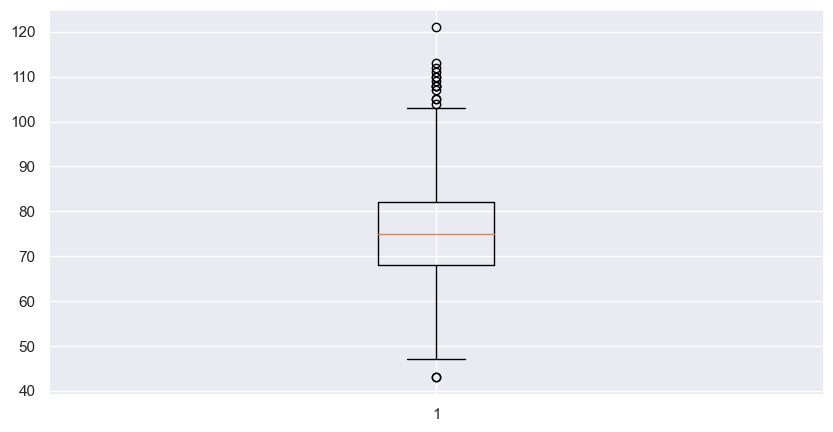

In [120]:
plt.boxplot(tourney_results.wscore)
plt.show()

In [121]:
print('wscore > 105: ', (tourney_results.wscore > 105).sum())
print('wscore > 110: ', (tourney_results.wscore > 110).sum())
tourney_results[tourney_results.wscore > 110]

wscore > 105:  11
wscore > 110:  4


,season,daynum,wteam,wscore,lteam,lscore
610,J,138,843,111,839,105
716,L,137,592,112,632,69
724,L,137,790,121,647,86
788,M,137,708,113,686,74


In [122]:
print('wscore < 50: ', (tourney_results.wscore < 50).sum())
tourney_results[tourney_results.wscore < 50]

wscore < 50:  4


,season,daynum,wteam,wscore,lteam,lscore
10,A,136,736,43,810,41
214,D,137,678,43,849,32
266,E,136,821,48,780,45
461,H,137,535,47,675,46


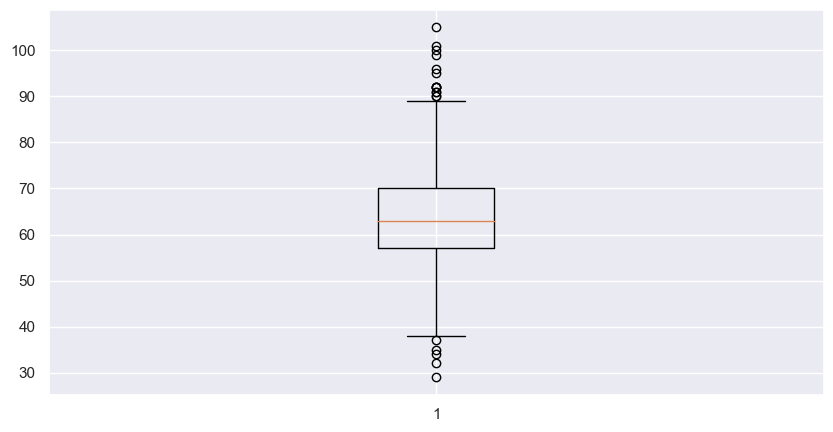

In [123]:
plt.boxplot(tourney_results.lscore)
plt.show()

In [124]:
print('lscore > 90: ', (tourney_results.lscore > 90).sum())
tourney_results[tourney_results.lscore > 90]

lscore > 90:  12


,season,daynum,wteam,wscore,lteam,lscore
77,B,136,829,101,648,91
121,B,146,511,96,737,92
427,G,139,810,105,549,101
476,H,138,511,96,607,95
480,H,138,660,101,676,92
536,I,137,805,102,840,100
610,J,138,843,111,839,105
688,K,144,559,98,840,92
795,M,137,835,101,575,99
877,N,143,676,102,666,91


In [125]:
print('lscore < 40: ', (tourney_results.lscore < 40).sum())
tourney_results[tourney_results.lscore < 40]

lscore < 40:  7


,season,daynum,wteam,wscore,lteam,lscore
214,D,137,678,43,849,32
259,E,136,671,65,826,38
341,F,137,671,69,506,35
382,G,136,577,84,848,37
774,M,136,810,70,685,29
1106,R,136,786,81,680,34
1149,R,145,786,55,660,39


Možemo vidjeti da u podacima nema stršećih vrijednosti. Ima par zapisa koji malo odskaču od ostalih, ali svi ti zapisi imaju vrijednosti wscore i lscore koje su moguće u košarci, tako da nećemo ništa poduzimati što se tiče tih vrijednosti. <br>
Sada ćemo grafički prikazati podatke. Prvo ćemo pogledati kako se prosječan broj poena pobjedničkih ekipa i prosječni broj poraženih ekipa kretao kroz sezone na završnom turniru.

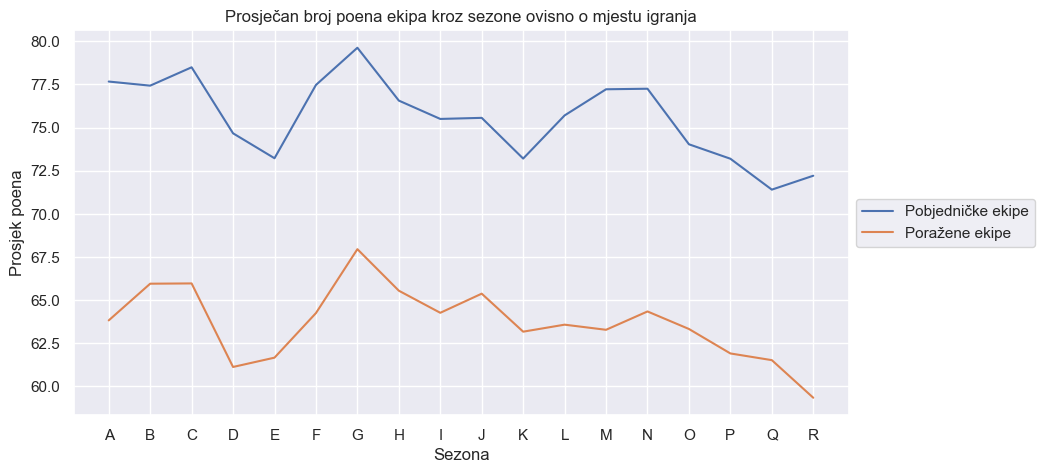

In [126]:
#Iteriramo po svim sezonama,pa nakon toga filtriramo podatke za određenu sezonu. Nakon toga računamo prosječan broj poena
#pobjedničkih ekipa, i prosječan broj poena poraženih ekipa i na kraju te podatke prikazujemo na grafu
sezone = "ABCDEFGHIJKLMNOPQR"
prosjeci_sezona_pobjede = []
prosjeci_sezona_porazi = []
for i in sezone:
    tourney_results_pom = tourney_results[(tourney_results.season == i)]
    pobjede = tourney_results_pom['wscore'].tolist()
    porazi = tourney_results_pom['lscore'].tolist()
    prosjeci_sezona_pobjede.append(np.nanmean(pobjede))
    prosjeci_sezona_porazi.append(np.nanmean(porazi))

plt.plot(list(sezone), prosjeci_sezona_pobjede, label="Pobjedničke ekipe")
plt.plot(list(sezone), prosjeci_sezona_porazi, label="Poražene ekipe")

plt.title("Prosječan broj poena ekipa kroz sezone ovisno o mjestu igranja")
plt.xlabel("Sezona")
plt.ylabel("Prosjek poena")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Sljedeće ćemo pogledati koje su ekipe osvajale završni turnir u svakoj sezoni, ima li ekipa koje su pobijedile više puta na završnom turniru te ću prikazati ekipe koje imaju najviše izgubljenih finala na završnim turnirima.

In [127]:
#Ova funkcija vraća pobjednika turnira za određenu sezonu
def getWinnerPerSeason(sezona):
    finale = tourney_results[(tourney_results.season == sezona) & (tourney_results.daynum == 154)]['daynum'].max()
    id_pobjednika = tourney_results[(tourney_results.season == sezona) & (tourney_results.daynum == finale)]['wteam'].tolist()[0]
    pobjednik = teams[teams.id == id_pobjednika]['name'].tolist()[0]
    return pobjednik

In [128]:
#Ispisujemo pobjednike svih 18 sezona
pobjednici_po_sezonama = {}
broj_pobjeda = {}
for i in sezone:
    pobjednici_po_sezonama[i] = getWinnerPerSeason(i)
print("Pobjednici završnog turnira po sezonama:")
for i, j in pobjednici_po_sezonama.items():
    print(f"{i} - {j}")
    if j not in broj_pobjeda.keys():
        broj_pobjeda[j] = 1
    else:
        broj_pobjeda[j] += 1

Pobjednici završnog turnira po sezonama:
A - Kentucky
B - Arizona
C - Kentucky
D - Connecticut
E - Michigan St
F - Duke
G - Maryland
H - Syracuse
I - Connecticut
J - North Carolina
K - Florida
L - Florida
M - Kansas
N - North Carolina
O - Duke
P - Connecticut
Q - Kentucky
R - Louisville


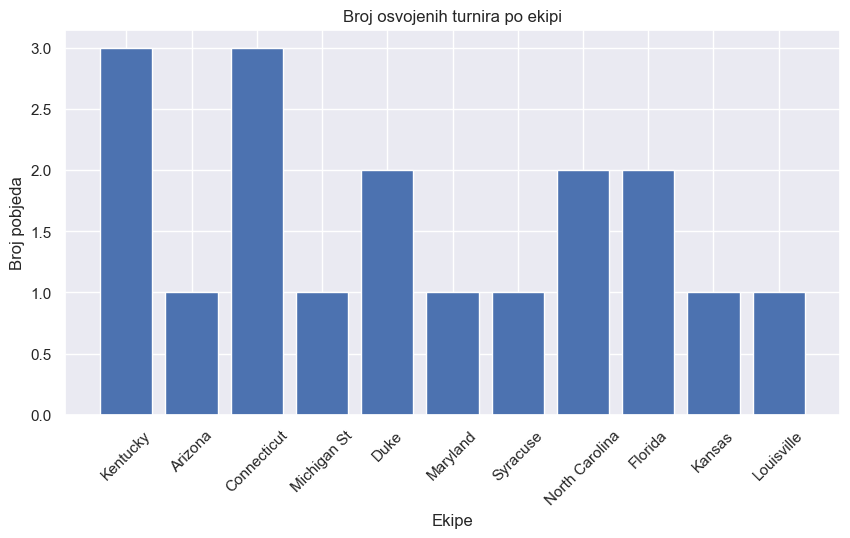

In [129]:
#Prikazujemoy sve pobjednike turnira na grafu
timovi = list(broj_pobjeda.keys())
rezultati = list(broj_pobjeda.values())
plt.bar(timovi, rezultati)
plt.title("Broj osvojenih turnira po ekipi")
plt.xlabel('Ekipe')
plt.ylabel('Broj pobjeda')
plt.xticks(rotation=45)
plt.show()

In [130]:
#Ova funkcija vraća ekipu koja je izgubila u finalu za određenu sezonu
def getLoserPerSeason(sezona):
    finale = tourney_results[(tourney_results.season == sezona) & (tourney_results.daynum == 154)]['daynum'].max()
    id_gubitnika = tourney_results[(tourney_results.season == sezona) & (tourney_results.daynum == finale)]['lteam'].tolist()[0]
    gubitnik = teams[teams.id == id_gubitnika]['name'].tolist()[0]
    return gubitnik

In [131]:
#Ispisujemo ekipe koje su izgubile u finalu za svih 18 sezona
gubitnici_po_sezonama = {}
broj_poraza_finale = {}
for i in sezone:
    gubitnici_po_sezonama[i] = getLoserPerSeason(i)
print("Ekipe koje su izgubile u finalu završnog turnira po sezonama:")
for i, j in gubitnici_po_sezonama.items():
    print(f"{i} - {j}")
    if j not in broj_poraza_finale.keys():
        broj_poraza_finale[j] = 1
    else:
        broj_poraza_finale[j] += 1

Ekipe koje su izgubile u finalu završnog turnira po sezonama:
A - Syracuse
B - Kentucky
C - Utah
D - Duke
E - Florida
F - Arizona
G - Indiana
H - Kansas
I - Georgia Tech
J - Illinois
K - UCLA
L - Ohio St
M - Memphis
N - Michigan St
O - Butler
P - Butler
Q - Kansas
R - Michigan


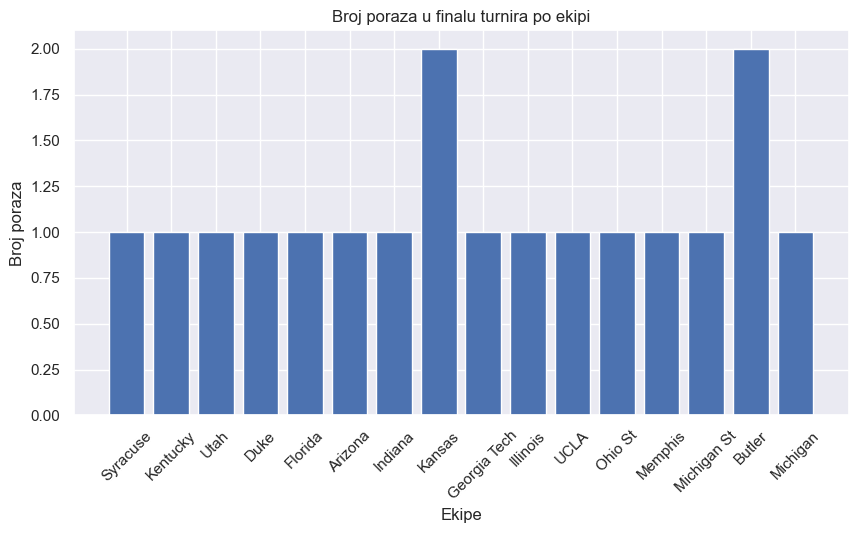

In [132]:
#Prikazujemo sve ekipe koje su izgubile u finalu na grafu
timovi = list(broj_poraza_finale.keys())
rezultati = list(broj_poraza_finale.values())
plt.bar(timovi, rezultati)
plt.title("Broj poraza u finalu turnira po ekipi")
plt.xlabel('Ekipe')
plt.ylabel('Broj poraza')
plt.xticks(rotation=45)
plt.show()

Iz gornjih grafova možemo vidjeti da smo imali 11 različitih pobjednika završnog turnira, te da je u finalu turnira sudjelovalo 20 različitih ekipa što nam govori da su ekipe jako izjednačene i niti jedna ne odskače previše od drugih. Najviše pobjeda završnog turnira u proteklih 18 godina imaju Kentucky i Connecticut, oboje po tri. Možemo također vidjeti da najviše izgubljenih finala imaju Kansas i Butler, oboje po dva. Možemo i vidjeti jednu zanimljivu stvar, Connecticut ima uz Kentucky najviše pobjeda u finalu, a niti jedan poraz, to znači da svaki put kad su došli do finala su i pobijedili u tom finalu.

Zadnje što ćemo izračunati i prikazati za tablicu tourney_results je korelaciju između svaka dva para značajki. S obzirom da imamo jednu ne numeričku značajku (season), njoj ćemo kao i kod tablice regular_season_results promijeniti format koristeči LabelEncoder.

In [133]:
le = LabelEncoder()
le.fit(tourney_results.loc[:,'season'])
tourney_results.loc[:,'season'] = le.transform(tourney_results.loc[:,'season'])

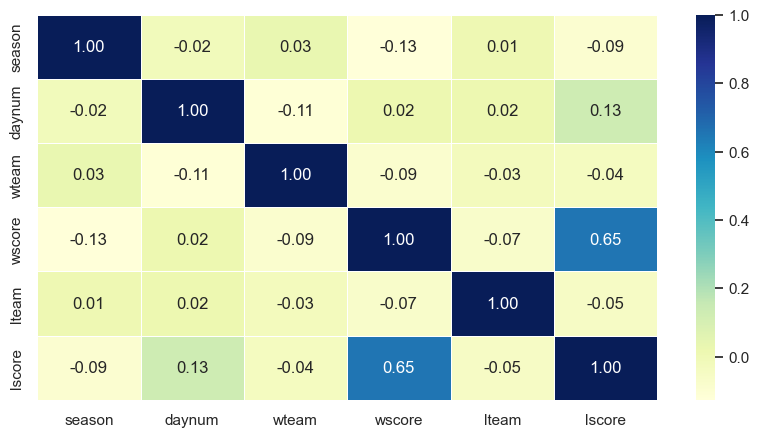

In [134]:
sns.set(rc={'figure.figsize':(10,5)})
sns.heatmap(tourney_results.corr(), annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.show()

# 2. Replikacija rezultata

U drugom dijelu projekta replicirat ćemo rezultate iz članka "A Machine Learning Strategy for Predicting March Madness Winners" by Gumm, Barrett, and Hu. Rezultate ćemo replicirati koristeći pristupe prikazane u članku. Uz pristupe iz članka pokušat ćemo replicirati i rezultate nekim alternativnim načinima i modelima te čemo usporediti rezultate. <br>
Za predviđanje rezultata korišten je agregatni model ansambla regresijskih funkcija izvedenih iz statističkih podataka s najvećom korelacijom razlike u pogledu pobjeda. Uz rezultate regularnog dijela sezone i završnog turnira korištena je i statistika sezone za svaku ekipu. <br>
Najprije čemo pogledati kako nam izgledaju nove tablice MNCAATourneyDetailedResults, MRegularSeasonDetailedResults i ordinals te da li postoje null vrijednosti.

In [135]:
MNCAATourneyDetailedResults = pd.read_csv("MNCAATourneyDetailedResults.csv")
MRegularSeasonDetailedResults = pd.read_csv("MRegularSeasonDetailedResults.csv")
ordinals = pd.read_csv("ordinals.csv")

In [136]:
MNCAATourneyDetailedResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,2022,146,1242,76,1274,50,N,0,29,58,...,21,9,13,5,21,7,14,7,4,20
1244,2022,146,1314,69,1389,49,N,0,25,61,...,16,9,10,4,25,11,7,4,7,18
1245,2022,152,1242,81,1437,65,N,0,29,54,...,31,8,10,12,17,12,9,3,0,11
1246,2022,152,1314,81,1181,77,N,0,27,64,...,22,12,20,13,25,12,4,7,4,18


In [137]:
MNCAATourneyDetailedResults.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 34 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Season   1248 non-null   int64 
 1   DayNum   1248 non-null   int64 
 2   WTeamID  1248 non-null   int64 
 3   WScore   1248 non-null   int64 
 4   LTeamID  1248 non-null   int64 
 5   LScore   1248 non-null   int64 
 6   WLoc     1248 non-null   object
 7   NumOT    1248 non-null   int64 
 8   WFGM     1248 non-null   int64 
 9   WFGA     1248 non-null   int64 
 10  WFGM3    1248 non-null   int64 
 11  WFGA3    1248 non-null   int64 
 12  WFTM     1248 non-null   int64 
 13  WFTA     1248 non-null   int64 
 14  WOR      1248 non-null   int64 
 15  WDR      1248 non-null   int64 
 16  WAst     1248 non-null   int64 
 17  WTO      1248 non-null   int64 
 18  WStl     1248 non-null   int64 
 19  WBlk     1248 non-null   int64 
 20  WPF      1248 non-null   int64 
 21  LFGM     1248 non-null   int64 
 22  

In [138]:
MNCAATourneyDetailedResults.isna().sum()

Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
WFGM       0
WFGA       0
WFGM3      0
WFGA3      0
WFTM       0
WFTA       0
WOR        0
WDR        0
WAst       0
WTO        0
WStl       0
WBlk       0
WPF        0
LFGM       0
LFGA       0
LFGM3      0
LFGA3      0
LFTM       0
LFTA       0
LOR        0
LDR        0
LAst       0
LTO        0
LStl       0
LBlk       0
LPF        0
dtype: int64

In [139]:
MRegularSeasonDetailedResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107629,2023,132,1104,82,1401,63,N,0,27,66,...,15,20,24,17,20,6,13,5,2,21
107630,2023,132,1272,75,1222,65,A,0,27,53,...,25,19,28,22,20,11,10,5,4,19
107631,2023,132,1343,74,1463,65,H,0,23,57,...,22,13,19,6,25,12,10,3,7,20
107632,2023,132,1345,67,1336,65,N,0,24,62,...,23,14,15,4,27,14,10,4,2,20


In [140]:
MRegularSeasonDetailedResults.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107634 entries, 0 to 107633
Data columns (total 34 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Season   107634 non-null  int64 
 1   DayNum   107634 non-null  int64 
 2   WTeamID  107634 non-null  int64 
 3   WScore   107634 non-null  int64 
 4   LTeamID  107634 non-null  int64 
 5   LScore   107634 non-null  int64 
 6   WLoc     107634 non-null  object
 7   NumOT    107634 non-null  int64 
 8   WFGM     107634 non-null  int64 
 9   WFGA     107634 non-null  int64 
 10  WFGM3    107634 non-null  int64 
 11  WFGA3    107634 non-null  int64 
 12  WFTM     107634 non-null  int64 
 13  WFTA     107634 non-null  int64 
 14  WOR      107634 non-null  int64 
 15  WDR      107634 non-null  int64 
 16  WAst     107634 non-null  int64 
 17  WTO      107634 non-null  int64 
 18  WStl     107634 non-null  int64 
 19  WBlk     107634 non-null  int64 
 20  WPF      107634 non-null  int64 
 21  LFGM     1

In [141]:
MRegularSeasonDetailedResults.isna().sum()

Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
WFGM       0
WFGA       0
WFGM3      0
WFGA3      0
WFTM       0
WFTA       0
WOR        0
WDR        0
WAst       0
WTO        0
WStl       0
WBlk       0
WPF        0
LFGM       0
LFGA       0
LFGM3      0
LFGA3      0
LFTM       0
LFTA       0
LOR        0
LDR        0
LAst       0
LTO        0
LStl       0
LBlk       0
LPF        0
dtype: int64

In [142]:
ordinals

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260
...,...,...,...,...,...
4922507,2023,128,WOL,1473,332
4922508,2023,128,WOL,1474,166
4922509,2023,128,WOL,1475,260
4922510,2023,128,WOL,1476,301


In [143]:
ordinals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4922512 entries, 0 to 4922511
Data columns (total 5 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   Season         int64 
 1   RankingDayNum  int64 
 2   SystemName     object
 3   TeamID         int64 
 4   OrdinalRank    int64 
dtypes: int64(4), object(1)
memory usage: 187.8+ MB


In [144]:
ordinals.isna().sum()

Season           0
RankingDayNum    0
SystemName       0
TeamID           0
OrdinalRank      0
dtype: int64

Za treniranje modela koristit ćemo samo podatke iz sezona 2011 do 2014 iz tablice MRegularSeasonDetailedResults, podatke iz sezona 2011 do 2014 iz tablice ordinals te podatke iz sezona 2011 do 2013 iz tablice MNCAATourneyDetailedResults. Za testiranje modela koristit ćemo podatke iz sezone 2014 iz tablice MNCAATourneyDetailedResults.

In [145]:
#Filtriramo podatke iz sezona 2011 do 2014 iz tablice MRegularSeasonDetailedResults i ordinals, te podatke iz sezona 2011 do 2013
#iz tablice MNCAATourneyDetailedResults. Nakon filtriranja podataka spajamo tablice MRegularSeasonDetailedResults_tmp i
#MNCAATourneyDetailedResults_tmp u jednu tablicu tmp
MRegularSeasonDetailedResults_tmp = MRegularSeasonDetailedResults[(MRegularSeasonDetailedResults.Season > 2010) & (MRegularSeasonDetailedResults.Season < 2015)]
MNCAATourneyDetailedResults_tmp = MNCAATourneyDetailedResults[(MNCAATourneyDetailedResults.Season > 2010) & (MNCAATourneyDetailedResults.Season < 2014)]
ordinals_tmp = ordinals[(ordinals.Season > 2010) & (ordinals.Season < 2015)]
tmp = pd.concat([MRegularSeasonDetailedResults_tmp,MNCAATourneyDetailedResults_tmp], axis=0)
tmp

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
39337,2011,7,1228,79,1414,65,H,0,29,58,...,20,14,22,11,26,12,14,7,1,21
39338,2011,7,1268,105,1370,76,H,0,35,62,...,16,17,22,18,16,11,27,18,1,31
39339,2011,7,1338,83,1348,75,H,0,29,64,...,32,13,16,10,21,16,17,7,6,25
39340,2011,7,1400,83,1298,52,H,0,30,59,...,23,10,18,8,22,8,16,5,5,24
39341,2011,9,1228,84,1405,45,H,0,37,64,...,12,10,19,6,17,9,23,6,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,2013,146,1257,85,1181,63,N,0,29,55,...,16,21,28,11,20,11,12,4,2,23
709,2013,146,1276,79,1196,59,N,0,30,65,...,10,11,17,9,27,13,15,7,3,11
710,2013,152,1257,72,1455,68,N,0,22,49,...,20,18,24,14,22,13,11,5,1,20
711,2013,152,1276,61,1393,56,N,0,21,53,...,14,7,11,10,23,13,10,7,4,19


Osnovni pristup koji ćemo prikazati je promatranje individualnih varijabli i izračunavanje različite košarkaške statistike. U ovom pristupu uzet ćemo razliku pobjedničkog i gubitničkog tima za svaku značajku.

In [146]:
imena_novih_znacajki = ['FGMdifference', 'FGAdifference', 'FGM3difference', 'FGA3difference', 'FTMdifference', 'FTAdifference', 'ORdifference', 'DRdifference', 'AstDdifference', 'TOdifference', 'StlDifference', 'BlkDifference', 'PFdifference']
imena_znacajki_wins = ['WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']
imena_znacajki_loses = ['LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']
nove_znacajke = pd.DataFrame(columns = imena_novih_znacajki)

#Računamo nove značajke kao razliku pobjedničkog i gubitničkog tima svake pojedine značajke.
for i in range(len(imena_novih_znacajki)):
    tmp[imena_novih_znacajki[i]] = tmp[imena_znacajki_wins[i]] - tmp[imena_znacajki_loses[i]]

tmp

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,FGA3difference,FTMdifference,FTAdifference,ORdifference,DRdifference,AstDdifference,TOdifference,StlDifference,BlkDifference,PFdifference
39337,2011,7,1228,79,1414,65,H,0,29,58,...,4,-1,1,-2,4,5,0,2,7,1
39338,2011,7,1268,105,1370,76,H,0,35,62,...,-8,16,19,-1,17,12,2,-9,8,-11
39339,2011,7,1338,83,1348,75,H,0,29,64,...,-17,9,14,8,7,3,-3,1,0,-7
39340,2011,7,1400,83,1298,52,H,0,30,59,...,-6,9,16,3,17,8,-1,0,0,-7
39341,2011,9,1228,84,1405,45,H,0,37,64,...,6,-5,-13,4,11,12,-9,4,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,2013,146,1257,85,1181,63,N,0,29,55,...,-3,4,8,0,6,-3,-4,6,7,0
709,2013,146,1276,79,1196,59,N,0,30,65,...,9,-2,-4,0,-1,5,-4,6,2,2
710,2013,152,1257,72,1455,68,N,0,22,49,...,5,1,5,-3,0,-3,-2,3,2,3
711,2013,152,1276,61,1393,56,N,0,21,53,...,10,4,9,3,1,4,0,-2,-1,-8


Nakon što smo izračunali naše nove značajke sada ćemo izračunati postotak pobjeda svake ekipe na našem skupu za učenje odnosno postotak pobjeda ekipa u regularnom dijelu za sezone 2011 do 2014 te završnom turniru za sezone 2011 do 2013.

In [147]:
ekipe = [i for i in range(1101,1465)]
ekipa_broj_pobjeda_poraza  = {}
postotak_pobjeda = {}
for j in ekipe:
    if j not in ekipa_broj_pobjeda_poraza:
        ekipa_broj_pobjeda_poraza[j] = [0, 0]
    if j not in postotak_pobjeda:
        postotak_pobjeda[j] = 0
        
#Iteriramo po svim zapisima te za svaku ekipu zapisujemo u rječnik koliko imaju pobjeda i poraza u sezoni
for index, row in tmp.iterrows():
    ekipa_broj_pobjeda_poraza[row.WTeamID][0] += 1
    ekipa_broj_pobjeda_poraza[row.LTeamID][1] += 1
        
#Izračunavamo postotak pobjeda svake ekipe i zapisujemo taj podataka u rječnik te nakon toga sve podatke zapisujemo u DataFrame.
for j in ekipa_broj_pobjeda_poraza.keys():
    if ekipa_broj_pobjeda_poraza[j][0] + ekipa_broj_pobjeda_poraza[j][1] != 0:
        postotak_pobjeda[j] = ekipa_broj_pobjeda_poraza[j][0] / (ekipa_broj_pobjeda_poraza[j][0] + ekipa_broj_pobjeda_poraza[j][1])
pobjede = pd.DataFrame(postotak_pobjeda.items(), columns=['Momcad', 'postotak_pobjede'])
pobjede

,Momcad,postotak_pobjede
0,1101,0.095238
1,1102,0.450450
2,1103,0.674242
3,1104,0.578125
4,1105,0.333333
...,...,...
359,1460,0.531746
360,1461,0.500000
361,1462,0.643939
362,1463,0.522936


Još nam je ostalo da za svaku ekipu izračunamo njezin prosječni RPI (Rating Percentage Index). Te podatke ćemo dobiti iz tablice ordinals u kojoj za svaku sezonu imamo zapisano koji je OrdinalRank imala ekipa za tu sezonu.

In [148]:
prosjecniRPI = {}
prosjecniRPI2 = {}
for i in ekipe:
    if i not in prosjecniRPI:
        prosjecniRPI[i] = [0, 0]

#Iteriramo po svim zapisima tablice ordinals_tmp (sadrži samo podatke za sezone 2011 do 2014) te u rječnik zapisujemo
#OrdinalRank-ove za svaku pojedinu ekipu
for index, row in ordinals_tmp.iterrows():
    prosjecniRPI[row.TeamID][0] += row.OrdinalRank
    prosjecniRPI[row.TeamID][1] += 1

In [149]:
#Računamo prosječni RPI za svaku ekipu te podatke zapisujemo u DataFrame
for j in prosjecniRPI.keys():
    if prosjecniRPI[j][1] != 0:
        prosjecniRPI2[j] = prosjecniRPI[j][0] / prosjecniRPI[j][1]
    else:
        ekipe.remove(j)

prosjek = pd.DataFrame(prosjecniRPI2.items(), columns=['TeamID', 'prosjecni_RPI'])
prosjek

,TeamID,prosjecni_RPI
0,1101,331.861004
1,1102,155.212392
2,1103,96.761150
3,1104,73.719448
4,1105,315.118290
...,...,...
347,1460,159.184707
348,1461,115.390718
349,1462,57.179680
350,1463,185.285005


Možemo vidjeti da nam tablica $pobjede$ koja sadrži postotke pobjeda svih ekipa ima 364 zapisa, 12 zapisa više nego tablica $prosjek$ koja sadrži zapise prosječnog RPI svake ekipe. Tih 12 zapisa su nam ekipe koje imaju postotak pobjede 0, odnosno nisu odigrale niti jednu utakmicu, ti zapisi nam ne trebaju te ćemo ih ukloniti.

In [150]:
pobjede = pobjede[pobjede.postotak_pobjede > 0.000001].reset_index(drop = True)
pobjede

,Momcad,postotak_pobjede
0,1101,0.095238
1,1102,0.450450
2,1103,0.674242
3,1104,0.578125
4,1105,0.333333
...,...,...
347,1460,0.531746
348,1461,0.500000
349,1462,0.643939
350,1463,0.522936


Nakon što smo uklonili zapise s ekipama koje nisu odigrale niti jednu utakmicu sada ćemo naše tablice $pobjede$ i $prosjek$ spojiti u jednu tablicu, koju ćemo nazvati $prosjek$_$po$_$ekipama$.

In [151]:
prosjek_po_ekipama = pd.concat([pobjede,prosjek], axis=1)
prosjek_po_ekipama

,Momcad,postotak_pobjede,TeamID,prosjecni_RPI
0,1101,0.095238,1101,331.861004
1,1102,0.450450,1102,155.212392
2,1103,0.674242,1103,96.761150
3,1104,0.578125,1104,73.719448
4,1105,0.333333,1105,315.118290
...,...,...,...,...
347,1460,0.531746,1460,159.184707
348,1461,0.500000,1461,115.390718
349,1462,0.643939,1462,57.179680
350,1463,0.522936,1463,185.285005


Vidimo da nam spojena tablica ima dva stupca koja predstavljaju jednu te istu značajku, $Momcad$ i $TeamID$. Jednu od njih ćemo ukloniti jer nam je nepotrebno imati oboje. Uklonit ćemo značajku $TeamID$.

In [152]:
prosjek_po_ekipama = prosjek_po_ekipama.drop(['TeamID'], axis = 1)
prosjek_po_ekipama

,Momcad,postotak_pobjede,prosjecni_RPI
0,1101,0.095238,331.861004
1,1102,0.450450,155.212392
2,1103,0.674242,96.761150
3,1104,0.578125,73.719448
4,1105,0.333333,315.118290
...,...,...,...
347,1460,0.531746,159.184707
348,1461,0.500000,115.390718
349,1462,0.643939,57.179680
350,1463,0.522936,185.285005


Još nam je ostalo za svaku ekipu izračunati prosjek za sve naše novo stvorene značajke ('FGMdifference', 'FGAdifference', 'FGM3difference', 'FGA3difference', 'FTMdifference', 'FTAdifference', 'ORdifference', 'DRdifference', 'AstDdifference', 'TOdifference', 'StlDifference', 'BlkDifference', 'PFdifference').

In [153]:
imena_novih_znacajki = ['FGMdifference', 'FGAdifference','FGM3difference', 'FGA3difference', 'FTMdifference', 'FTAdifference', 'ORdifference', 'DRdifference', 'AstDdifference', 'TOdifference', 'StlDifference', 'BlkDifference', 'PFdifference']
prosjeci_svih_ekipa = []
for i in range(len(ekipe)):
    prosjeci_svih_ekipa.append([])

#Iteriramo po svim ekipama, te zatim za svaku ekipu filtriramo sve zapise u kojima je ta ekipa ili pobijedila ili izgubila. Nakon 
#toga za svaku značajku sumiramo sve njezine vrijednosti te izračunamo prosjek za svaku ekipu. Sve te podatke spremimo u DataFrame.
brojac = 0
for i in ekipe:
    tmp2 = tmp[(tmp.WTeamID == i)]
    tmp3 = tmp[(tmp.LTeamID == i)]
    for j in imena_novih_znacajki:
        rez1 = tmp2[j].sum() / tmp2.shape[0]
        rez2 = -tmp3[j].sum() / tmp3.shape[0]
        rez = rez1 + rez2
        prosjeci_svih_ekipa[brojac].append(rez)
    brojac += 1

prosjeci_svih_ekipa2 = pd.DataFrame(prosjeci_svih_ekipa, columns=['FGMavg', 'FGAavg','FGM3avg', 'FGA3avg', 'FTMavg', 'FTAavg', 'ORavg', 'DRavg', 'AstAvg', 'TOavg', 'StlAvg', 'BlkAvg', 'PFavg'])
prosjeci_svih_ekipa2

,FGMavg,FGAavg,FGM3avg,FGA3avg,FTMavg,FTAavg,ORavg,DRavg,AstAvg,TOavg,StlAvg,BlkAvg,PFavg
0,-11.105263,-7.657895,1.184211,1.842105,7.052632,1.157895,-5.315789,-1.921053,-8.842105,2.710526,-0.026316,-3.447368,-1.263158
1,0.052459,-6.531803,-0.281639,-4.434754,-1.691803,-2.472131,-7.469508,-1.032131,1.823934,-0.468525,-0.355082,-1.627869,-0.857705
2,0.287170,0.875359,2.985890,7.736347,-2.647243,-1.457539,0.682519,-0.918474,1.095114,0.303632,-0.176378,1.935981,0.668931
3,3.624124,0.667167,-0.809810,-2.879880,-1.391391,-2.407407,-1.427427,1.906907,0.767768,-1.353353,3.704204,1.061061,3.583584
4,-0.902778,0.166667,1.083333,4.027778,-3.375000,-4.958333,-0.583333,-0.944444,2.513889,1.152778,-1.236111,1.805556,1.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0.955477,5.930686,1.100683,0.952441,-2.464204,-4.558816,-1.968884,-5.796104,0.386036,-5.716418,2.910448,-3.240071,2.676195
348,-0.932203,-4.949153,0.135593,1.711864,3.440678,5.440678,-5.135593,-2.288136,1.915254,-2.305085,1.915254,1.847458,-4.000000
349,2.736170,-1.980976,-3.593492,-10.189487,1.277096,2.757196,1.137422,4.399249,-1.726658,1.141176,-0.449061,-1.609762,-1.474343
350,-2.969636,-2.851215,-1.178812,-0.193320,4.828273,6.012821,2.774291,1.631579,-0.364710,2.578273,-1.831984,0.089406,-3.284413


Sada ćemo tablice prosjeci_svih_ekipa2 i prosjeci_svih_ekipa spojiti u jednu tablicu koju ćemo nazvati svi_podaci. Ta tablica sadrži sve podatke koji će nam biti potrebni za treniranje modela.

In [154]:
svi_podaci = pd.concat([prosjek_po_ekipama, prosjeci_svih_ekipa2], axis=1)
svi_podaci

,Momcad,postotak_pobjede,prosjecni_RPI,FGMavg,FGAavg,FGM3avg,FGA3avg,FTMavg,FTAavg,ORavg,DRavg,AstAvg,TOavg,StlAvg,BlkAvg,PFavg
0,1101,0.095238,331.861004,-11.105263,-7.657895,1.184211,1.842105,7.052632,1.157895,-5.315789,-1.921053,-8.842105,2.710526,-0.026316,-3.447368,-1.263158
1,1102,0.450450,155.212392,0.052459,-6.531803,-0.281639,-4.434754,-1.691803,-2.472131,-7.469508,-1.032131,1.823934,-0.468525,-0.355082,-1.627869,-0.857705
2,1103,0.674242,96.761150,0.287170,0.875359,2.985890,7.736347,-2.647243,-1.457539,0.682519,-0.918474,1.095114,0.303632,-0.176378,1.935981,0.668931
3,1104,0.578125,73.719448,3.624124,0.667167,-0.809810,-2.879880,-1.391391,-2.407407,-1.427427,1.906907,0.767768,-1.353353,3.704204,1.061061,3.583584
4,1105,0.333333,315.118290,-0.902778,0.166667,1.083333,4.027778,-3.375000,-4.958333,-0.583333,-0.944444,2.513889,1.152778,-1.236111,1.805556,1.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,1460,0.531746,159.184707,0.955477,5.930686,1.100683,0.952441,-2.464204,-4.558816,-1.968884,-5.796104,0.386036,-5.716418,2.910448,-3.240071,2.676195
348,1461,0.500000,115.390718,-0.932203,-4.949153,0.135593,1.711864,3.440678,5.440678,-5.135593,-2.288136,1.915254,-2.305085,1.915254,1.847458,-4.000000
349,1462,0.643939,57.179680,2.736170,-1.980976,-3.593492,-10.189487,1.277096,2.757196,1.137422,4.399249,-1.726658,1.141176,-0.449061,-1.609762,-1.474343
350,1463,0.522936,185.285005,-2.969636,-2.851215,-1.178812,-0.193320,4.828273,6.012821,2.774291,1.631579,-0.364710,2.578273,-1.831984,0.089406,-3.284413


Analizirat ćemo korelaciju između svake od ovih varijabli i postotka pobjede pojedine ekipe da pobijedi svog protivnika. Šest varijabli s najvećim koeficijentom korelacije bit će odabrane za provođenje nelinearne (kvadratne) regresijske analize. Istrenirat ćemo šest modela, za svaku značajku jedan. Potom ćemo za izračunavanje predikcija za svaku utakmicu izračunati prosjek svih šest regresijskih funkcija.

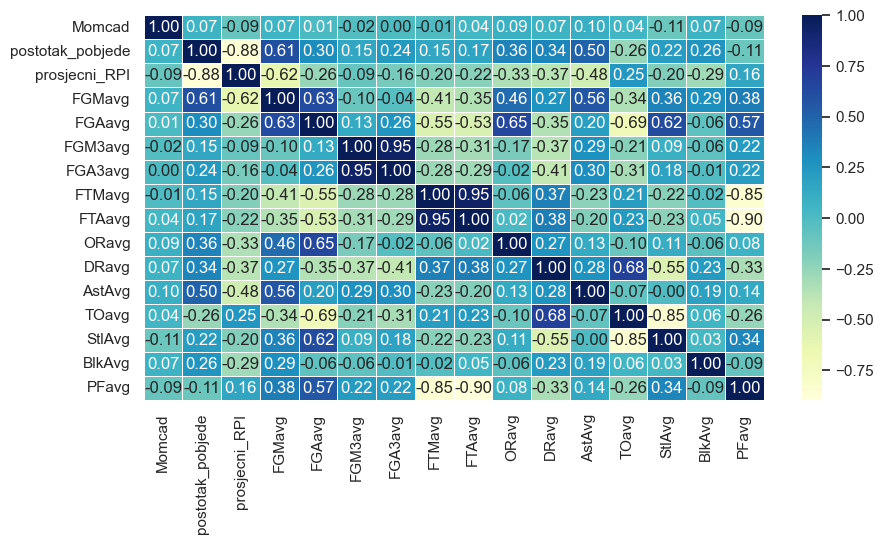

In [155]:
sns.set(rc={'figure.figsize':(10,5)})
sns.heatmap(svi_podaci.corr(), annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.show()

Šest značajki koje nam najviše koreliraju s postotkom pobjeda su $prosjecni$_$RPI$ (average RPI), $FGMavg$ (average field goals made), $AstAvg$ (average assists), $ORavg$ (average offensive rebounds), $DRavg$ (average defensive rebounds), $FGAavg$ (average field goals attempted). Sada ćemo za svaku značajku napraviti model nelinearne (kvadratne) regresije. Te ćemo grafički prikazati sve dobivene modele i skupove podataka.

In [156]:
najvaznije_znacajke = ['prosjecni_RPI', 'FGMavg', 'AstAvg', 'ORavg', 'DRavg', 'FGAavg']
y_train = np.array(svi_podaci["postotak_pobjede"].tolist())
X_train = []
for i in range(len(najvaznije_znacajke)):
    X_train.append(np.array(svi_podaci[najvaznije_znacajke[i]].tolist()))

lista_modela = []
for i in range(len(X_train)):
    model = np.poly1d(np.polyfit(X_train[i], y_train, 2))
    lista_modela.append(model)
    string = f"{i + 1}. {najvaznije_znacajke[i]}: y = {model.c[0]}x² + {model.c[1]}x + {model.c[2]}"
    print(string)

1. prosjecni_RPI: y = -1.0454264847813177e-06x² + -0.0011592223767222718x + 0.7345089755986549
2. FGMavg: y = 0.0013148799675023499x² + 0.04037735614483399x + 0.489314322060044
3. AstAvg: y = -0.0002744467443319452x² + 0.02793579867711265x + 0.49640064434331077
4. ORavg: y = -0.00035475051730574894x² + 0.018578999280966502x + 0.49538644776233787
5. DRavg: y = 0.0011778638422419534x² + 0.01806559146420415x + 0.4814868883456127
6. FGAavg: y = -0.0001655737138907392x² + 0.009267680998927537x + 0.4957769971885338


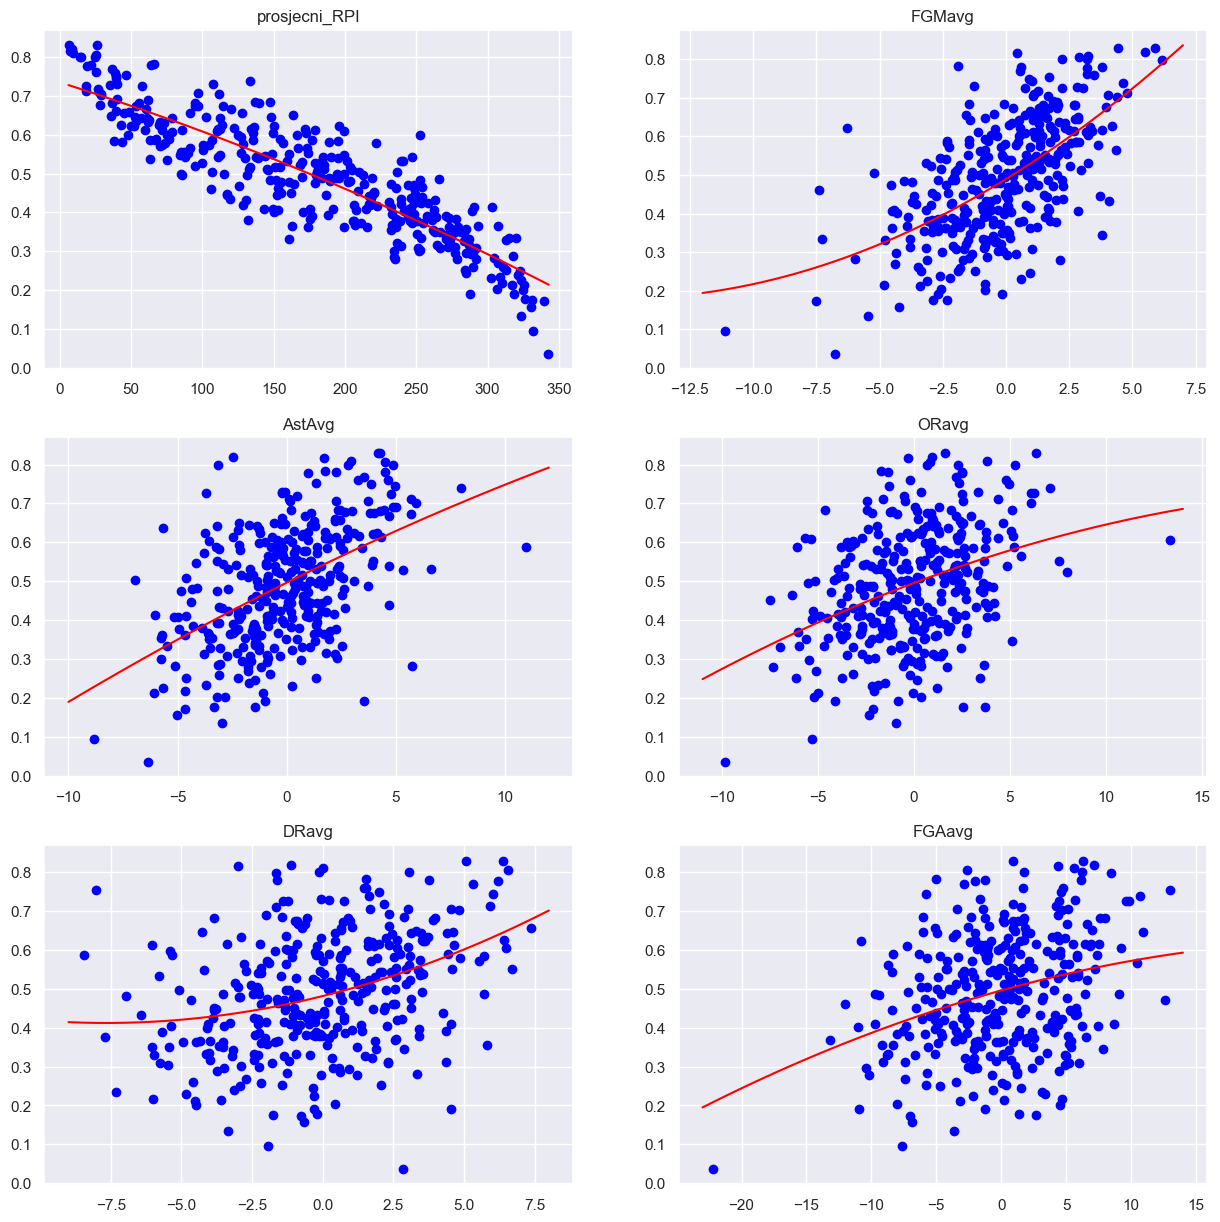

In [159]:
fig, axs = plt.subplots(3, 2, figsize=(15,15))
for i in range(len(lista_modela)):
    row = i // 2
    col = i % 2
    x_values = np.linspace(round(min(X_train[i])) - 1, round(max(X_train[i])) + 1, 1000)
    y_values = lista_modela[i](x_values)
    plt.sca(axs[row, col])
    plt.title(najvaznije_znacajke[i])
    plt.scatter(X_train[i], y_train, color='blue')
    plt.plot(x_values, y_values, color='red')
    plt.grid(True)
plt.show()

Jedino što nam je ostalo je testirati naše modele. To ćemo napraviti na pripremljenom skupu za testiranje koje sadrži rezultate završnog turnira za sezonu 2014.

In [160]:
X_test = MNCAATourneyDetailedResults[MNCAATourneyDetailedResults.Season == 2014]
X_test

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
713,2014,134,1107,71,1291,64,N,0,27,47,...,37,8,12,6,17,13,4,3,1,16
714,2014,134,1301,74,1462,59,N,0,29,53,...,14,11,16,11,20,7,13,3,0,17
715,2014,135,1142,81,1411,69,N,0,29,51,...,13,17,22,11,16,12,13,3,1,23
716,2014,135,1397,78,1234,65,N,1,24,54,...,16,13,15,7,23,14,6,2,2,28
717,2014,136,1163,89,1386,81,N,1,30,66,...,21,20,27,9,24,12,14,3,2,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,2014,146,1163,60,1277,54,N,0,17,49,...,29,7,8,6,26,13,16,5,3,16
776,2014,146,1246,75,1276,72,N,0,31,58,...,18,11,14,14,10,11,7,4,1,14
777,2014,152,1163,63,1196,53,N,0,24,43,...,10,14,20,12,15,3,11,3,1,14
778,2014,152,1246,74,1458,73,N,0,29,58,...,20,19,20,6,21,11,8,4,3,18


In [161]:
import math
tocno = 0
krivo = 0

#Iteriramo po svim zapisima iz našeg skupa za testiranje. Za svaki zapis iščitamo pobjedničku i poraženu ekipu. Nakon toga iteriramo 
#po podacima na kojima smo naučili modele. U listu lista_pob spremit ćemo vrijednosti naših šest značajki koje najviše koreliraju
#s postotkom pobjeda od pobjedničke ekipe i u listu lista_por vrijednosti naših šest značajki od poražene ekipe.
for index, row in X_test.iterrows():
    lista_por = []
    lista_pob = []
    pobjednik = row['WTeamID']
    porazeni = row['LTeamID']
    for index1, row1 in svi_podaci.iterrows():
        if pobjednik == row1['Momcad']:
            for i in najvaznije_znacajke:
                rez = row1[i]
                lista_pob.append(rez)
        elif porazeni == row1['Momcad']:
            for i in najvaznije_znacajke:
                rez = row1[i]
                lista_por.append(rez)

#Nako što spremimo vrijednosti naših šest značajki za pobjedničku i poraženu ekipu računamo njihovu razliku te dobivene vrijednosti
#uvrštavamo u naših šest modela. Za predikciju uzimamo prosjek izračunatih vrijednosti svih šest modela, te provjeravamo je li
#vrijednost veća ili manja od 0.5. Ako je veća klasificiramo primjer kao točan, ako je manji klasificiramo ga kao krivo. Na kraju
#ispišemo točnost modela.
    x = []
    for i in range(len(najvaznije_znacajke)):
        rez = lista_pob[i] - lista_por[i]
        x.append(rez)
    predikcija = 0
    for i in range(len(lista_modela)):
        predikcija += lista_modela[i].c[0] * math.pow(x[i], 2) + lista_modela[i].c[1] * x[i] + lista_modela[i].c[2]
    predikcija = predikcija / len(lista_modela)
    if predikcija >= 0.5:
        tocno += 1
    else:
        krivo += 1

tocnost = tocno / (tocno + krivo)
print("Točnost modela: " + str(round(tocnost, 4) * 100) + "%")

Točnost modela: 83.58%


Dobili smo jako dobru točnost našeg modela, čak i bolju nego u članku "A Machine Learning Strategy for Predicting March Madness Winners" by Gumm, Barrett, and Hu po kojemu repliciramo rezultate.

# 3. Poboljšanje rezultata